In [1]:
!pip install pmdarima

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import scipy
import warnings
import seaborn as sns
import scipy.stats as stats
import math

from scipy.stats import pearsonr

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings('ignore')

import datetime as datetime

# Introduction

This notebook will explore vaccination rates between Canada and the United States. The data will be based off the original covid_df dataset. Once vaccination rates have been determined, visualized, and modeled, hospitalizations will be analyzed to investigate the correlation between vaccination rates and hospitalization rates. 

# Data import and initial inspection

In [2]:
vaccine_df = pd.read_csv('Covid19-vaccination.csv')

In [3]:
covid_df = pd.read_csv('Complete_covid19_dataset.csv')

In [4]:
vaccine_df.head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003


In [5]:
vaccine_df.dtypes

location                                object
iso_code                                object
date                                    object
total_vaccinations                     float64
people_vaccinated                      float64
people_fully_vaccinated                float64
total_boosters                         float64
daily_vaccinations_raw                 float64
daily_vaccinations                     float64
total_vaccinations_per_hundred         float64
people_vaccinated_per_hundred          float64
people_fully_vaccinated_per_hundred    float64
total_boosters_per_hundred             float64
daily_vaccinations_per_million         float64
daily_people_vaccinated                float64
daily_people_vaccinated_per_hundred    float64
dtype: object

In [6]:
covid_df['date'] = pd.to_datetime(covid_df['date']).dt.date

In [7]:
vaccine_df['date'] = pd.to_datetime(vaccine_df['date']).dt.date

In [8]:
vaccine_df.shape

(63006, 16)

In [9]:
vaccine_df.columns

Index(['location', 'iso_code', 'date', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'daily_vaccinations_per_million', 'daily_people_vaccinated',
       'daily_people_vaccinated_per_hundred'],
      dtype='object')

In [10]:
vaccine_df['location'].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'England', 'Equatorial Guinea', 'Estonia',
       'Eswatini', 'Ethi

In [11]:
vaccine_df['location'].unique().shape

(235,)

In [12]:
covid_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [13]:
covid_df.shape

(134459, 67)

In [14]:
covid_df['location'].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

In [15]:
covid_df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [16]:
covid_df['location'].unique().shape

(237,)

## Notes
- There are differences between the datasets in terms of location

In [17]:
for column in vaccine_df.columns.tolist():
    if column not in (covid_df.columns.tolist()):
        print("Vaccine column not in covid columns: " + str(column))

Vaccine column not in covid columns: daily_vaccinations_raw
Vaccine column not in covid columns: daily_vaccinations
Vaccine column not in covid columns: daily_vaccinations_per_million
Vaccine column not in covid columns: daily_people_vaccinated
Vaccine column not in covid columns: daily_people_vaccinated_per_hundred


In [18]:
covid_df[['new_vaccinations']].copy()

,new_vaccinations
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
134454,24589.0
134455,37816.0
134456,NaN
134457,NaN


In [19]:
vaccine_df[['daily_vaccinations_raw']].copy()

,daily_vaccinations_raw
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
63001,NaN
63002,NaN
63003,52068.0
63004,33513.0


Notes
- Preliminary exploration and cleaning will be done with vaccine_df to explore the initial findings on Canada
    - The findings found here will be used to get a "feel" of handling the data to deal with covid_df
- Cleaning and data preparation for covid_df will be done later

# Preliminary data cleaning -  vaccine_df

In [20]:
vaccine_df.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                     27277
people_vaccinated                      28883
people_fully_vaccinated                31853
total_boosters                         56393
daily_vaccinations_raw                 33083
daily_vaccinations                       326
total_vaccinations_per_hundred         27277
people_vaccinated_per_hundred          28883
people_fully_vaccinated_per_hundred    31853
total_boosters_per_hundred             56393
daily_vaccinations_per_million           326
daily_people_vaccinated                 1558
daily_people_vaccinated_per_hundred     1558
dtype: int64

In [21]:
covid_df.isna().sum()

iso_code                                        0
continent                                    8578
location                                        0
date                                            0
total_cases                                  7393
                                            ...  
human_development_index                     18176
excess_mortality_cumulative_absolute       129736
excess_mortality_cumulative                129736
excess_mortality                           129736
excess_mortality_cumulative_per_million    129736
Length: 67, dtype: int64

In [22]:
vaccine_df.iloc[vaccine_df[vaccine_df.total_vaccinations.notnull()].index.tolist()]

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN
6,Afghanistan,AFG,2021-02-28,8200.0,8200.0,NaN,NaN,NaN,1367.0,0.02,0.02,NaN,NaN,34.0,1367.0,0.003
22,Afghanistan,AFG,2021-03-16,54000.0,54000.0,NaN,NaN,NaN,2862.0,0.14,0.14,NaN,NaN,72.0,2862.0,0.007
44,Afghanistan,AFG,2021-04-07,120000.0,120000.0,NaN,NaN,NaN,3000.0,0.30,0.30,NaN,NaN,75.0,3000.0,0.008
59,Afghanistan,AFG,2021-04-22,240000.0,240000.0,NaN,NaN,NaN,8000.0,0.60,0.60,NaN,NaN,201.0,8000.0,0.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63000,Zimbabwe,ZWE,2021-11-16,6228119.0,3515140.0,2712979.0,NaN,37816.0,24487.0,41.27,23.29,17.98,NaN,1622.0,17188.0,0.114
63002,Zimbabwe,ZWE,2021-11-18,6310431.0,3583256.0,2727175.0,NaN,NaN,29822.0,41.81,23.74,18.07,NaN,1976.0,22810.0,0.151
63003,Zimbabwe,ZWE,2021-11-19,6362499.0,3625221.0,2737278.0,NaN,52068.0,33163.0,42.16,24.02,18.14,NaN,2197.0,25915.0,0.172
63004,Zimbabwe,ZWE,2021-11-20,6396012.0,3651820.0,2744192.0,NaN,33513.0,34377.0,42.38,24.20,18.18,NaN,2278.0,26983.0,0.179


In [23]:
vaccine_df.iloc[vaccine_df[vaccine_df.total_vaccinations.isna()].index.tolist()]

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
5,Afghanistan,AFG,2021-02-27,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62918,Zimbabwe,ZWE,2021-08-26,NaN,NaN,NaN,NaN,NaN,60688.0,NaN,NaN,NaN,NaN,4021.0,34170.0,0.226
62929,Zimbabwe,ZWE,2021-09-06,NaN,NaN,NaN,NaN,NaN,41445.0,NaN,NaN,NaN,NaN,2746.0,25649.0,0.170
62935,Zimbabwe,ZWE,2021-09-12,NaN,NaN,NaN,NaN,NaN,41351.0,NaN,NaN,NaN,NaN,2740.0,18276.0,0.121
62940,Zimbabwe,ZWE,2021-09-17,NaN,NaN,NaN,NaN,NaN,45993.0,NaN,NaN,NaN,NaN,3047.0,15908.0,0.105


In [24]:
covid_df.iloc[covid_df[covid_df.total_vaccinations.notnull()].index.tolist()]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
364,AFG,Asia,Afghanistan,2021-02-22,55617.0,13.0,14.714,2433.0,1.0,0.857,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
370,AFG,Asia,Afghanistan,2021-02-28,55714.0,7.0,15.714,2443.0,0.0,1.571,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
386,AFG,Asia,Afghanistan,2021-03-16,55995.0,10.0,17.000,2460.0,1.0,1.286,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
408,AFG,Asia,Afghanistan,2021-04-07,56873.0,94.0,59.857,2512.0,0.0,4.000,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
423,AFG,Asia,Afghanistan,2021-04-22,58312.0,98.0,111.143,2561.0,4.0,4.000,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134453,ZWE,Africa,Zimbabwe,2021-11-14,133428.0,35.0,34.429,4696.0,0.0,1.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
134454,ZWE,Africa,Zimbabwe,2021-11-15,133438.0,10.0,33.286,4697.0,1.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
134455,ZWE,Africa,Zimbabwe,2021-11-16,133505.0,67.0,37.571,4698.0,1.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
134457,ZWE,Africa,Zimbabwe,2021-11-18,133593.0,36.0,37.714,4699.0,0.0,0.714,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


## Notes
- The entire dataset will first need to be cleaned and prepared, then visualized
- Canada will be isolated to its own df as part of the preliminary data cleaning and exploration step
- With respect to vaccinations, some of the rows will not have any useful data and will only give NaN, so these can safely be replaced with zeros
    - I am not going to remove them explicitely because this is time-series analysis and I want the same number of data points between vaccinations and hospitalizations when plotting

In [25]:
canada_vaccine_df = vaccine_df.loc[vaccine_df['location'] == 'Canada'].copy().reset_index(inplace = False)

In [26]:
canada_vaccine_df.shape

(343, 17)

In [27]:
canada_vaccine_df.head()

,index,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,9795,Canada,CAN,2020-12-14,5.0,5.0,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN
1,9796,Canada,CAN,2020-12-15,727.0,727.0,NaN,NaN,722.0,722.0,0.00,0.00,NaN,NaN,19.0,722.0,0.002
2,9797,Canada,CAN,2020-12-16,3016.0,3016.0,NaN,NaN,2289.0,1506.0,0.01,0.01,NaN,NaN,40.0,1506.0,0.004
3,9798,Canada,CAN,2020-12-17,7267.0,7267.0,NaN,NaN,4251.0,2421.0,0.02,0.02,NaN,NaN,64.0,2421.0,0.006
4,9799,Canada,CAN,2020-12-18,11276.0,11276.0,NaN,NaN,4009.0,2818.0,0.03,0.03,NaN,NaN,74.0,2818.0,0.007


In [28]:
canada_vaccine_df.isna().sum()

index                                   0
location                                0
iso_code                                0
date                                    0
total_vaccinations                      0
people_vaccinated                       0
people_fully_vaccinated                15
total_boosters                         59
daily_vaccinations_raw                  1
daily_vaccinations                      1
total_vaccinations_per_hundred          0
people_vaccinated_per_hundred           0
people_fully_vaccinated_per_hundred    15
total_boosters_per_hundred             59
daily_vaccinations_per_million          1
daily_people_vaccinated                 1
daily_people_vaccinated_per_hundred     1
dtype: int64

## Notes
- it appears that the very first row is fileld with NaN. 
- This makes sense since it wwas when vaccinations started, there was no number to base off of, so I will replace NaN on this row with 0

In [29]:
canada_vaccine_df = canada_vaccine_df.fillna(value = 0, limit = 1)

In [30]:
canada_vaccine_df.isna().sum()

index                                   0
location                                0
iso_code                                0
date                                    0
total_vaccinations                      0
people_vaccinated                       0
people_fully_vaccinated                14
total_boosters                         58
daily_vaccinations_raw                  0
daily_vaccinations                      0
total_vaccinations_per_hundred          0
people_vaccinated_per_hundred           0
people_fully_vaccinated_per_hundred    14
total_boosters_per_hundred             58
daily_vaccinations_per_million          0
daily_people_vaccinated                 0
daily_people_vaccinated_per_hundred     0
dtype: int64

In [31]:
canada_vaccine_df.head()

,index,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,9795,Canada,CAN,2020-12-14,5.0,5.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000
1,9796,Canada,CAN,2020-12-15,727.0,727.0,NaN,NaN,722.0,722.0,0.00,0.00,NaN,NaN,19.0,722.0,0.002
2,9797,Canada,CAN,2020-12-16,3016.0,3016.0,NaN,NaN,2289.0,1506.0,0.01,0.01,NaN,NaN,40.0,1506.0,0.004
3,9798,Canada,CAN,2020-12-17,7267.0,7267.0,NaN,NaN,4251.0,2421.0,0.02,0.02,NaN,NaN,64.0,2421.0,0.006
4,9799,Canada,CAN,2020-12-18,11276.0,11276.0,NaN,NaN,4009.0,2818.0,0.03,0.03,NaN,NaN,74.0,2818.0,0.007


In [32]:
canada_vaccine_df.iloc[canada_vaccine_df[canada_vaccine_df.total_boosters_per_hundred.isna()].index.tolist()]

,index,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
1,9796,Canada,CAN,2020-12-15,727.0,727.0,NaN,NaN,722.0,722.0,0.00,0.00,NaN,NaN,19.0,722.0,0.002
2,9797,Canada,CAN,2020-12-16,3016.0,3016.0,NaN,NaN,2289.0,1506.0,0.01,0.01,NaN,NaN,40.0,1506.0,0.004
3,9798,Canada,CAN,2020-12-17,7267.0,7267.0,NaN,NaN,4251.0,2421.0,0.02,0.02,NaN,NaN,64.0,2421.0,0.006
4,9799,Canada,CAN,2020-12-18,11276.0,11276.0,NaN,NaN,4009.0,2818.0,0.03,0.03,NaN,NaN,74.0,2818.0,0.007
5,9800,Canada,CAN,2020-12-19,12042.0,12042.0,NaN,NaN,766.0,2407.0,0.03,0.03,NaN,NaN,63.0,2407.0,0.006
6,9801,Canada,CAN,2020-12-20,12901.0,12901.0,NaN,NaN,859.0,2149.0,0.03,0.03,NaN,NaN,56.0,2149.0,0.006
7,9802,Canada,CAN,2020-12-21,21043.0,21043.0,NaN,NaN,8142.0,3005.0,0.06,0.06,NaN,NaN,79.0,3005.0,0.008
8,9803,Canada,CAN,2020-12-22,26826.0,26826.0,NaN,NaN,5783.0,3728.0,0.07,0.07,NaN,NaN,98.0,3728.0,0.010
9,9804,Canada,CAN,2020-12-23,35503.0,35503.0,NaN,NaN,8677.0,4641.0,0.09,0.09,NaN,NaN,122.0,4641.0,0.012
10,9805,Canada,CAN,2020-12-24,45698.0,45698.0,NaN,NaN,10195.0,5490.0,0.12,0.12,NaN,NaN,144.0,5490.0,0.014


## Notes
- All the boostershots are in the same consecutive timeline, so I can fill in the NaN values with zero

In [33]:
canada_vaccine_df[['total_boosters', 'total_boosters_per_hundred']] = canada_vaccine_df[['total_boosters', 'total_boosters_per_hundred']].fillna(value = 0)

In [34]:
canada_vaccine_df.iloc[canada_vaccine_df[canada_vaccine_df.people_fully_vaccinated.isna()].index.tolist()]

,index,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
1,9796,Canada,CAN,2020-12-15,727.0,727.0,NaN,0.0,722.0,722.0,0.00,0.00,NaN,0.0,19.0,722.0,0.002
2,9797,Canada,CAN,2020-12-16,3016.0,3016.0,NaN,0.0,2289.0,1506.0,0.01,0.01,NaN,0.0,40.0,1506.0,0.004
3,9798,Canada,CAN,2020-12-17,7267.0,7267.0,NaN,0.0,4251.0,2421.0,0.02,0.02,NaN,0.0,64.0,2421.0,0.006
4,9799,Canada,CAN,2020-12-18,11276.0,11276.0,NaN,0.0,4009.0,2818.0,0.03,0.03,NaN,0.0,74.0,2818.0,0.007
5,9800,Canada,CAN,2020-12-19,12042.0,12042.0,NaN,0.0,766.0,2407.0,0.03,0.03,NaN,0.0,63.0,2407.0,0.006
6,9801,Canada,CAN,2020-12-20,12901.0,12901.0,NaN,0.0,859.0,2149.0,0.03,0.03,NaN,0.0,56.0,2149.0,0.006
7,9802,Canada,CAN,2020-12-21,21043.0,21043.0,NaN,0.0,8142.0,3005.0,0.06,0.06,NaN,0.0,79.0,3005.0,0.008
8,9803,Canada,CAN,2020-12-22,26826.0,26826.0,NaN,0.0,5783.0,3728.0,0.07,0.07,NaN,0.0,98.0,3728.0,0.010
9,9804,Canada,CAN,2020-12-23,35503.0,35503.0,NaN,0.0,8677.0,4641.0,0.09,0.09,NaN,0.0,122.0,4641.0,0.012
10,9805,Canada,CAN,2020-12-24,45698.0,45698.0,NaN,0.0,10195.0,5490.0,0.12,0.12,NaN,0.0,144.0,5490.0,0.014


## Notes
- All the fully vaccinated are in the same consecutive timeline, so I also believe it is safe for me to fill NaN with zero since this is before vaccines were rolled out

In [35]:
canada_vaccine_df[['people_fully_vaccinated', 'people_fully_vaccinated_per_hundred']] = canada_vaccine_df[['people_fully_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred']].fillna(value = 0)

In [36]:
canada_vaccine_df.isna().sum()

index                                  0
location                               0
iso_code                               0
date                                   0
total_vaccinations                     0
people_vaccinated                      0
people_fully_vaccinated                0
total_boosters                         0
daily_vaccinations_raw                 0
daily_vaccinations                     0
total_vaccinations_per_hundred         0
people_vaccinated_per_hundred          0
people_fully_vaccinated_per_hundred    0
total_boosters_per_hundred             0
daily_vaccinations_per_million         0
daily_people_vaccinated                0
daily_people_vaccinated_per_hundred    0
dtype: int64

## Notes
- Preliminary cleanup complete for vaccine_df
- NaN values at the very start of country datasets may be replaced with zeros safely
- I will now see if I can apply the same process to investigate the covid_df dataset with Canada

# Preliminary cleanup for covid_df vaccination rates

In [37]:
#first only select the desired columns

In [38]:
covid_df = covid_df[['iso_code', 'continent', 'location', 'date', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred']].copy()

In [39]:
covid_df.isna().sum()

iso_code                                           0
continent                                       8578
location                                           0
date                                               0
total_deaths                                   18574
new_deaths                                     18378
new_deaths_smoothed                             8438
total_deaths_per_million                       19213
new_deaths_per_million                         19017
new_deaths_smoothed_per_million                 9085
icu_patients                                  118315
icu_patients_per_million                      118315
hosp_patients                                 115535
hosp_patients_per_million                     115535
weekly_icu_admissions                         133103
weekly_icu_admissions_per_million             133103
weekly_hosp_admissions                        132305
weekly_hosp_admissions_per_million            132305
total_vaccinations                            

In [40]:
canada_covid_df = covid_df.loc[covid_df['location'] == 'Canada'].copy().reset_index(inplace = False)

In [41]:
canada_covid_df.shape

(664, 32)

In [42]:
canada_covid_df.head()

,index,iso_code,continent,location,date,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,...,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred
0,21310,CAN,North America,Canada,2020-01-26,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21311,CAN,North America,Canada,2020-01-27,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21312,CAN,North America,Canada,2020-01-28,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21313,CAN,North America,Canada,2020-01-29,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21314,CAN,North America,Canada,2020-01-30,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
canada_covid_df.isna().sum()

index                                           0
iso_code                                        0
continent                                       0
location                                        0
date                                            0
total_deaths                                   43
new_deaths                                     43
new_deaths_smoothed                             5
total_deaths_per_million                       43
new_deaths_per_million                         43
new_deaths_smoothed_per_million                 5
icu_patients                                   44
icu_patients_per_million                       44
hosp_patients                                  44
hosp_patients_per_million                      44
weekly_icu_admissions                         664
weekly_icu_admissions_per_million             664
weekly_hosp_admissions                        664
weekly_hosp_admissions_per_million            664
total_vaccinations                            323


In [44]:
canada_covid_df = canada_covid_df[['date', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred']].copy()

In [45]:
canada_covid_df.iloc[canada_covid_df[canada_covid_df.total_boosters_per_hundred.isna()].index.tolist()]

,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred
0,2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,2021-02-06,1079202.0,907344.0,171858.0,NaN,21709.0,16328.0,2.83,2.38,0.45,NaN,429.0,7616.0,0.020
378,2021-02-07,1093062.0,913422.0,179640.0,NaN,13860.0,17488.0,2.87,2.40,0.47,NaN,459.0,8030.0,0.021
379,2021-02-08,1114446.0,923864.0,190582.0,NaN,21384.0,17908.0,2.93,2.43,0.50,NaN,470.0,7539.0,0.020
380,2021-02-09,1140762.0,933230.0,207532.0,NaN,26316.0,20011.0,3.00,2.45,0.55,NaN,526.0,7925.0,0.021


## Notes
- It appears that the NaN values for the vaccine-related columns are similar to the issue found with canada_vaccine_df, where the NaN are because the boosters were not applied yet. 
- I will follow the same procedure and replace NaN values for boosters with zeros because this is the same timeline boosters were not distributed

In [46]:
canada_covid_df[['total_boosters', 'total_boosters_per_Hundred']] = canada_vaccine_df[['total_boosters', 'total_boosters_per_hundred']].fillna(value = 0)

In [47]:
canada_covid_df.iloc[canada_covid_df[canada_covid_df.people_fully_vaccinated.isna()].index.tolist()]

,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,total_boosters_per_Hundred
0,2020-01-26,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
1,2020-01-27,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
2,2020-01-28,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
3,2020-01-29,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
4,2020-01-30,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,2020-12-24,45698.0,45698.0,NaN,810373.0,10195.0,5490.0,0.12,0.12,NaN,NaN,144.0,5490.0,0.014,2.13
334,2020-12-25,48744.0,48744.0,NaN,817009.0,3046.0,5353.0,0.13,0.13,NaN,NaN,141.0,5353.0,0.014,2.15
335,2020-12-26,48759.0,48759.0,NaN,819203.0,15.0,5245.0,0.13,0.13,NaN,NaN,138.0,5245.0,0.014,2.15
336,2020-12-27,52368.0,52368.0,NaN,859285.0,3609.0,5638.0,0.14,0.14,NaN,NaN,148.0,5638.0,0.015,2.26


## Notes
- All the fully vaccinated are in the same consecutive timeline like in vaccine_df, so I also believe it is safe for me to fill NaN with zero since this is before vaccines were rolled out


In [48]:
canada_covid_df[['people_fully_vaccinated', 'people_fully_vaccinated_per_hundred']] = canada_covid_df[['people_fully_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred']].fillna(value = 0)

In [49]:
canada_covid_df.isna().sum()

date                                            0
total_vaccinations                            323
people_vaccinated                             323
people_fully_vaccinated                         0
total_boosters                                321
new_vaccinations                              324
new_vaccinations_smoothed                     324
total_vaccinations_per_hundred                323
people_vaccinated_per_hundred                 323
people_fully_vaccinated_per_hundred             0
total_boosters_per_hundred                    382
new_vaccinations_smoothed_per_million         324
new_people_vaccinated_smoothed                324
new_people_vaccinated_smoothed_per_hundred    324
total_boosters_per_Hundred                    321
dtype: int64

Notes
- Given that the rates are based on per_hundred and per_million, I believe it is safe to fill all the other NaN values  with 0 

In [50]:
canada_covid_df = canada_covid_df.fillna(value = 0)

In [51]:
canada_covid_df.isna().sum()

date                                          0
total_vaccinations                            0
people_vaccinated                             0
people_fully_vaccinated                       0
total_boosters                                0
new_vaccinations                              0
new_vaccinations_smoothed                     0
total_vaccinations_per_hundred                0
people_vaccinated_per_hundred                 0
people_fully_vaccinated_per_hundred           0
total_boosters_per_hundred                    0
new_vaccinations_smoothed_per_million         0
new_people_vaccinated_smoothed                0
new_people_vaccinated_smoothed_per_hundred    0
total_boosters_per_Hundred                    0
dtype: int64

In [52]:
canada_covid_df.dtypes

date                                           object
total_vaccinations                            float64
people_vaccinated                             float64
people_fully_vaccinated                       float64
total_boosters                                float64
new_vaccinations                              float64
new_vaccinations_smoothed                     float64
total_vaccinations_per_hundred                float64
people_vaccinated_per_hundred                 float64
people_fully_vaccinated_per_hundred           float64
total_boosters_per_hundred                    float64
new_vaccinations_smoothed_per_million         float64
new_people_vaccinated_smoothed                float64
new_people_vaccinated_smoothed_per_hundred    float64
total_boosters_per_Hundred                    float64
dtype: object

In [53]:
#Preliminary cleanup complete 

# Preliminary visualization of Canada_vaccine_df

<AxesSubplot:title={'center':'Canadians vaccinated'}, xlabel='date', ylabel='People vaccinated per hundred'>

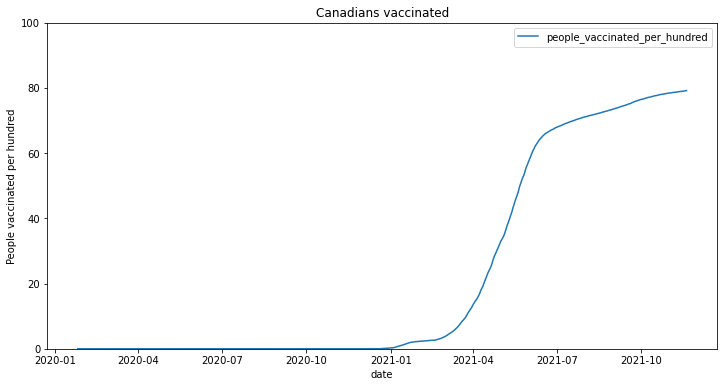

In [54]:
canada_covid_df.plot(x = 'date', y = 'people_vaccinated_per_hundred', figsize = (12, 6), title = 'Canadians vaccinated', xlabel = 'date', ylabel = 'People vaccinated per hundred', ylim = (0, 100))

<AxesSubplot:title={'center':'Daily Canadians vaccinated'}, xlabel='date', ylabel='daily_people_vaccinated_per_hundred'>

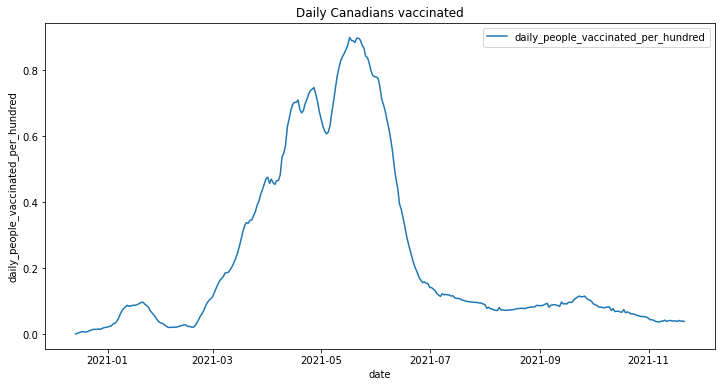

In [55]:
canada_vaccine_df.plot(x = 'date', y = 'daily_people_vaccinated_per_hundred', figsize = (12, 6), title = 'Daily Canadians vaccinated', xlabel = 'date', ylabel = 'daily_people_vaccinated_per_hundred')

## Notes
- it appears the vaccination rate in Canada was also like an S-curve, slow initially, then exponential growth, then slow again (like a logistic function / logistic growth)
- It appears that the vaccination rate is reaching a point of saturation if viewed like a logistic function
- The daily people vaccinated per hundred almost reminds me of a normal distribution of some sorts or like the derivative of a generalized logistic function
- time to check booster shots (see below)

<AxesSubplot:title={'center':'Canadians with booster shots per hundred'}, xlabel='date', ylabel='People boosted per hundred'>

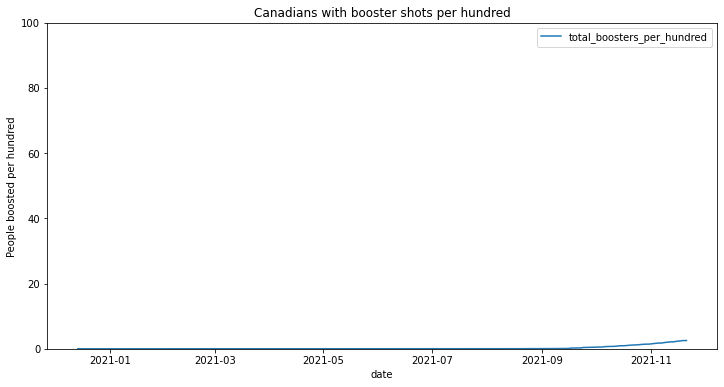

In [56]:
canada_vaccine_df.plot(x = 'date', y = 'total_boosters_per_hundred', figsize = (12, 6), title = 'Canadians with booster shots per hundred', xlabel = 'date', ylabel = 'People boosted per hundred', ylim = (0, 100))

<AxesSubplot:title={'center':'Canadians with booster shots per hundred'}, xlabel='date', ylabel='People boosted per hundred'>

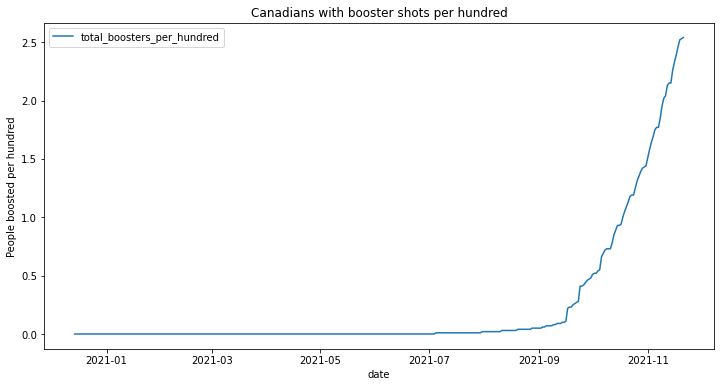

In [57]:
canada_vaccine_df.plot(x = 'date', y = 'total_boosters_per_hundred', figsize = (12, 6), title = 'Canadians with booster shots per hundred', xlabel = 'date', ylabel = 'People boosted per hundred')

<AxesSubplot:title={'center':'Canadians with booster shots'}, xlabel='date', ylabel='Total boosters'>

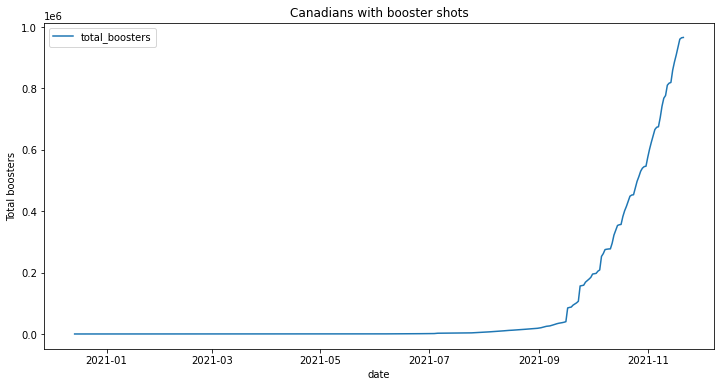

In [58]:
canada_vaccine_df.plot(x = 'date', y = 'total_boosters', figsize = (12, 6), title = 'Canadians with booster shots', xlabel = 'date', ylabel = 'Total boosters')

## Preliminary visualization for canada_covid_df

<AxesSubplot:title={'center':'Canadians vaccinated per hundred'}, xlabel='date', ylabel='people vaccinated per hundred'>

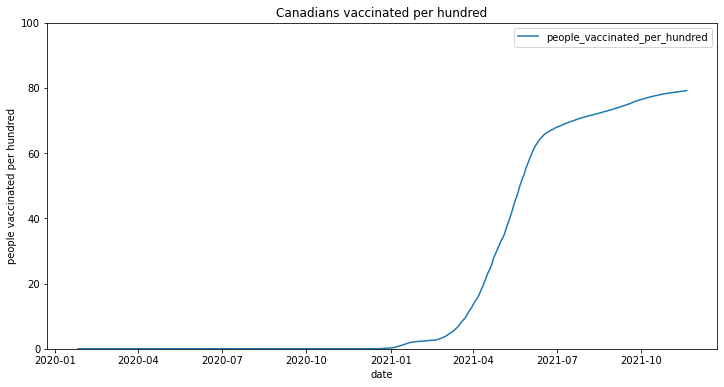

In [59]:
canada_covid_df.plot(x = 'date', y = 'people_vaccinated_per_hundred', figsize = (12, 6), title = "Canadians vaccinated per hundred", xlabel = 'date', ylabel = 'people vaccinated per hundred', ylim = (0, 100))

<AxesSubplot:title={'center':'Daily Canadians vaccinated'}, xlabel='date', ylabel='People smoothed per hundred'>

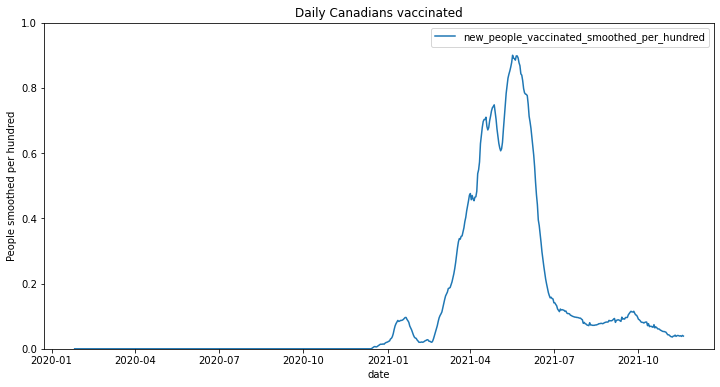

In [60]:
canada_covid_df.plot(x = 'date', y = 'new_people_vaccinated_smoothed_per_hundred', figsize = (12, 6), title = 'Daily Canadians vaccinated', xlabel = 'date', ylabel = 'People smoothed per hundred', ylim = (0, 1))

<AxesSubplot:title={'center':'Daily Canadians fully vaccinated'}, xlabel='date', ylabel='Fully vaccinated per hundred'>

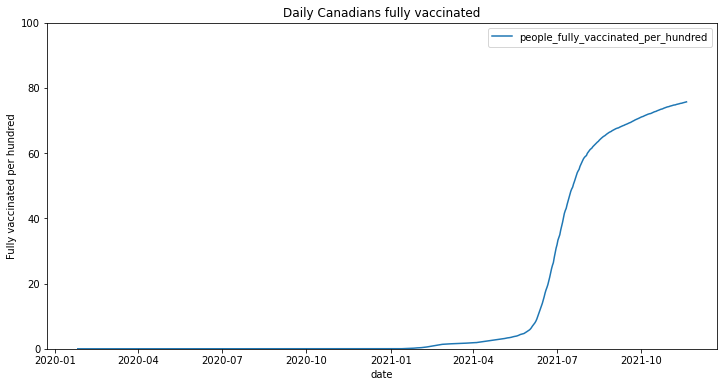

In [61]:
canada_covid_df.plot(x = 'date', y = 'people_fully_vaccinated_per_hundred', figsize = (12, 6), title = 'Daily Canadians fully vaccinated', xlabel = 'date', ylabel = 'Fully vaccinated per hundred', ylim = (0, 100))

## Preliminary findings: Conclusion and next steps

NaN values in terms of vaccinations per day, vaccinations per hundred, vaccinations per million, daily boosters, boosters per million can be safely replaced with zeros. Eearly dates before 2020-12 can be replaced with zeros because they do not provided more information, at least in terms of Canada. This may be applicable when analyzing other countries. When US vaccination rates will be investigated, this same methodology will be followed. Given that the total vaccinations and the vaccinations_per_hundred are the same shape, the focus will be in terms of per hundred because this allows vaccination rates to be scaled appropriately because of the varying population sizes of different nations. I do need to be aware that by selecting only a few set of columns from the main dataset, this may mean the data will result in an entire row of NaN values. If this is the case, then the row will be replaced with zeros to maintain the same length of data points for plotting. In terms of missing data, I intend to run a p-test to see if there are correlations with vaccination rates. If not, then I intend to use an alternate method to fill in the NaN values. I have a gut feeling telling me that some values can be fixed without needding to derive it from other features. More specifically, to use the interpolate method from pandas. If this does not fix all the NaN values, I will need to investigate these cells manually. 

# Data cleanup

In [62]:
covid_vaccine_df = covid_df[['iso_code', 'location', 'date', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred']].copy()

In [63]:
covid_vaccine_df.head()

,iso_code,location,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred
0,AFG,Afghanistan,2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,Afghanistan,2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AFG,Afghanistan,2020-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AFG,Afghanistan,2020-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Notes
- Again, I mentioned this earlier, but some of the rows are entirely NaN, so I believe these rows can be set to zero safely

In [64]:
covid_vaccine_df.shape

(134459, 16)

In [65]:
covid_vaccine_df.isna().sum()

iso_code                                           0
location                                           0
date                                               0
total_vaccinations                            100183
people_vaccinated                             101780
people_fully_vaccinated                       104757
total_boosters                                128101
new_vaccinations                              105959
new_vaccinations_smoothed                      73280
total_vaccinations_per_hundred                100183
people_vaccinated_per_hundred                 101780
people_fully_vaccinated_per_hundred           104757
total_boosters_per_hundred                    128101
new_vaccinations_smoothed_per_million          73280
new_people_vaccinated_smoothed                 74503
new_people_vaccinated_smoothed_per_hundred     74503
dtype: int64

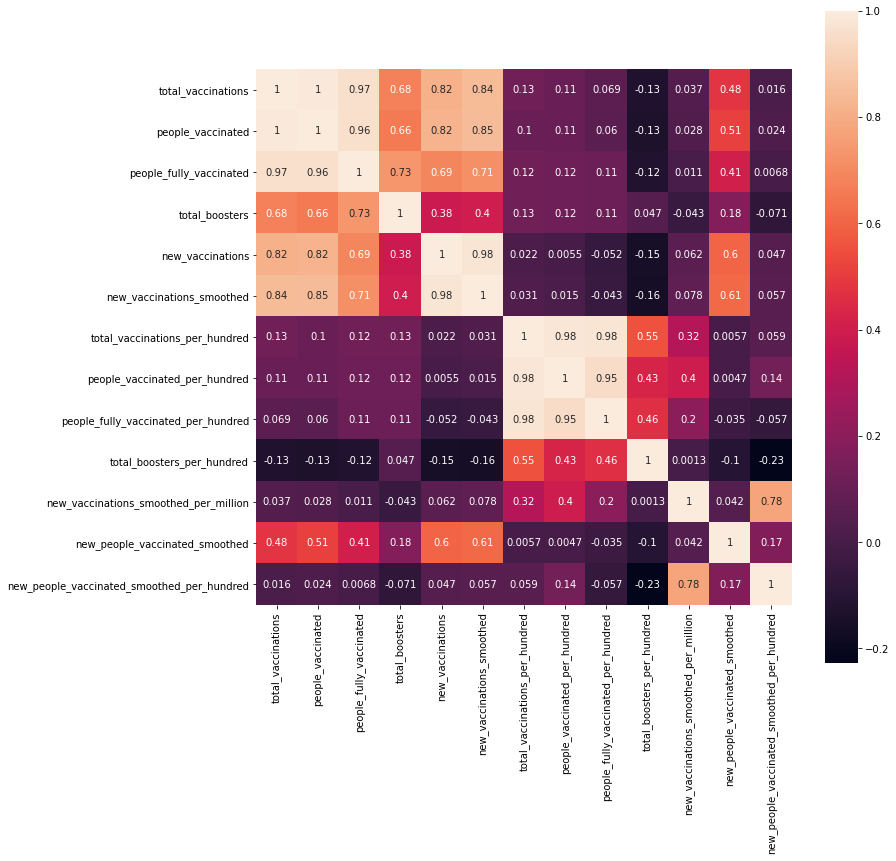

In [66]:
plt.subplots(figsize = (12, 12))
sns.heatmap(covid_vaccine_df.corr(), annot = True, square = True)
plt.show()

## Notes
- It appears that there is little to no correlation between people vacicnated and the vaccinations_per_hundred
    - this may mean I might have to pursue the interpolation route instead of deriving from another column
- the lines of code below are me manually investigating different aspects of the data

In [67]:
nan_df = covid_vaccine_df.iloc[covid_vaccine_df[covid_vaccine_df.people_vaccinated.isna()].index]

In [68]:
nan_df.shape

(101780, 16)

In [69]:
nan_df

,iso_code,location,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred
0,AFG,Afghanistan,2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,Afghanistan,2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AFG,Afghanistan,2020-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AFG,Afghanistan,2020-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134373,ZWE,Zimbabwe,2021-08-26,NaN,NaN,NaN,NaN,NaN,60688.0,NaN,NaN,NaN,NaN,4021.0,34170.0,0.226
134384,ZWE,Zimbabwe,2021-09-06,NaN,NaN,NaN,NaN,NaN,41445.0,NaN,NaN,NaN,NaN,2746.0,25649.0,0.170
134390,ZWE,Zimbabwe,2021-09-12,NaN,NaN,NaN,NaN,NaN,41351.0,NaN,NaN,NaN,NaN,2740.0,18276.0,0.121
134395,ZWE,Zimbabwe,2021-09-17,NaN,NaN,NaN,NaN,NaN,45993.0,NaN,NaN,NaN,NaN,3047.0,15908.0,0.105


In [70]:
china_df = covid_vaccine_df.loc[covid_vaccine_df['location'] == 'China']

In [71]:
china_df

,iso_code,location,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred
24768,CHN,China,2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24769,CHN,China,2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24770,CHN,China,2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24771,CHN,China,2020-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24772,CHN,China,2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25431,CHN,China,2021-11-15,2.396045e+09,NaN,NaN,NaN,6477000.0,8221714.0,165.91,NaN,NaN,NaN,5693.0,2002548.0,0.139
25432,CHN,China,2021-11-16,2.402897e+09,NaN,NaN,NaN,6852000.0,8009429.0,166.38,NaN,NaN,NaN,5546.0,2002548.0,0.139
25433,CHN,China,2021-11-17,2.409784e+09,NaN,NaN,NaN,6887000.0,7751286.0,166.86,NaN,NaN,NaN,5367.0,2002548.0,0.139
25434,CHN,China,2021-11-18,2.416179e+09,NaN,NaN,NaN,6395000.0,7449571.0,167.30,NaN,NaN,NaN,5158.0,2002548.0,0.139


In [72]:
china_df.iloc[-2].notna()

iso_code                                       True
location                                       True
date                                           True
total_vaccinations                             True
people_vaccinated                             False
people_fully_vaccinated                       False
total_boosters                                False
new_vaccinations                               True
new_vaccinations_smoothed                      True
total_vaccinations_per_hundred                 True
people_vaccinated_per_hundred                 False
people_fully_vaccinated_per_hundred           False
total_boosters_per_hundred                    False
new_vaccinations_smoothed_per_million          True
new_people_vaccinated_smoothed                 True
new_people_vaccinated_smoothed_per_hundred     True
Name: 25434, dtype: bool

In [73]:
china_df[['total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred']].iloc[-2].notna()

total_vaccinations                             True
people_vaccinated                             False
people_fully_vaccinated                       False
total_boosters                                False
new_vaccinations                               True
new_vaccinations_smoothed                      True
total_vaccinations_per_hundred                 True
people_vaccinated_per_hundred                 False
people_fully_vaccinated_per_hundred           False
total_boosters_per_hundred                    False
new_vaccinations_smoothed_per_million          True
new_people_vaccinated_smoothed                 True
new_people_vaccinated_smoothed_per_hundred     True
Name: 25434, dtype: bool

## Notes
- Further confirming that some rows are only NaN, I intend to set them to zero

In [74]:
not any(china_df[['total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred']].iloc[-2].notna())

False

In [75]:
china_df.people_vaccinated.isna().sum()

663

In [76]:
china_df.iloc[0].notna()

iso_code                                       True
location                                       True
date                                           True
total_vaccinations                            False
people_vaccinated                             False
people_fully_vaccinated                       False
total_boosters                                False
new_vaccinations                              False
new_vaccinations_smoothed                     False
total_vaccinations_per_hundred                False
people_vaccinated_per_hundred                 False
people_fully_vaccinated_per_hundred           False
total_boosters_per_hundred                    False
new_vaccinations_smoothed_per_million         False
new_people_vaccinated_smoothed                False
new_people_vaccinated_smoothed_per_hundred    False
Name: 24768, dtype: bool

In [77]:
china_df[['total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred']].iloc[0].notna()

total_vaccinations                            False
people_vaccinated                             False
people_fully_vaccinated                       False
total_boosters                                False
new_vaccinations                              False
new_vaccinations_smoothed                     False
total_vaccinations_per_hundred                False
people_vaccinated_per_hundred                 False
people_fully_vaccinated_per_hundred           False
total_boosters_per_hundred                    False
new_vaccinations_smoothed_per_million         False
new_people_vaccinated_smoothed                False
new_people_vaccinated_smoothed_per_hundred    False
Name: 24768, dtype: bool

In [78]:
covid_vaccine_df.shape

(134459, 16)

In [79]:
covid_vaccine_df.isna().sum()

iso_code                                           0
location                                           0
date                                               0
total_vaccinations                            100183
people_vaccinated                             101780
people_fully_vaccinated                       104757
total_boosters                                128101
new_vaccinations                              105959
new_vaccinations_smoothed                      73280
total_vaccinations_per_hundred                100183
people_vaccinated_per_hundred                 101780
people_fully_vaccinated_per_hundred           104757
total_boosters_per_hundred                    128101
new_vaccinations_smoothed_per_million          73280
new_people_vaccinated_smoothed                 74503
new_people_vaccinated_smoothed_per_hundred     74503
dtype: int64

In [80]:
#Now, the goal is to interpolate if there is missing data

In [81]:
def country_interpolate_vaccine(country, original_df, column_list):
    country_df = original_df.loc[original_df['location'] == country].copy()
    country_df_idx = country_df.index
    
    
    for column in column_list:
        interpolate_column = country_df[column].interpolate()
        country_df[column] = interpolate_column
    
    #Now that most of the Nan values have been interpolated, this means any NaN values left are before people were fully vaccinated or required boosters
    #These NaN values will be among the first few lines, meaning booster rollout did not start.
    #So, any other NaN can safely be filled with zero. 
    #This will ensure the dimensions of the data will remain intact when comparing vaccine rates to hospitalization rates later

    
    country_df = country_df.fillna(0)
    
    
    return country_df

            
        
        
    
    

In [82]:
country_interpolate_vaccine('China', covid_vaccine_df, ['total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred'])

,iso_code,location,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred
24768,CHN,China,2020-01-22,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.000
24769,CHN,China,2020-01-23,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.000
24770,CHN,China,2020-01-24,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.000
24771,CHN,China,2020-01-25,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.000
24772,CHN,China,2020-01-26,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25431,CHN,China,2021-11-15,2.396045e+09,1.216990e+09,1.074901e+09,5.642143e+07,6477000.0,8221714.0,165.91,84.265161,74.427143,3.904286,5693.0,2002548.0,0.139
25432,CHN,China,2021-11-16,2.402897e+09,1.218992e+09,1.075252e+09,5.874857e+07,6852000.0,8009429.0,166.38,84.403871,74.452857,4.065714,5546.0,2002548.0,0.139
25433,CHN,China,2021-11-17,2.409784e+09,1.220995e+09,1.075604e+09,6.107571e+07,6887000.0,7751286.0,166.86,84.542581,74.478571,4.227143,5367.0,2002548.0,0.139
25434,CHN,China,2021-11-18,2.416179e+09,1.222997e+09,1.075956e+09,6.340286e+07,6395000.0,7449571.0,167.30,84.681290,74.504286,4.388571,5158.0,2002548.0,0.139


In [83]:
for country in covid_vaccine_df['location'].unique():
    covid_vaccine_df.update(country_interpolate_vaccine(country, covid_vaccine_df, ['total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred']))

In [84]:
covid_vaccine_df.head()

,iso_code,location,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred
0,AFG,Afghanistan,2020-02-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AFG,Afghanistan,2020-02-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AFG,Afghanistan,2020-02-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AFG,Afghanistan,2020-02-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AFG,Afghanistan,2020-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
covid_vaccine_df.isna().sum()

iso_code                                      0
location                                      0
date                                          0
total_vaccinations                            0
people_vaccinated                             0
people_fully_vaccinated                       0
total_boosters                                0
new_vaccinations                              0
new_vaccinations_smoothed                     0
total_vaccinations_per_hundred                0
people_vaccinated_per_hundred                 0
people_fully_vaccinated_per_hundred           0
total_boosters_per_hundred                    0
new_vaccinations_smoothed_per_million         0
new_people_vaccinated_smoothed                0
new_people_vaccinated_smoothed_per_hundred    0
dtype: int64

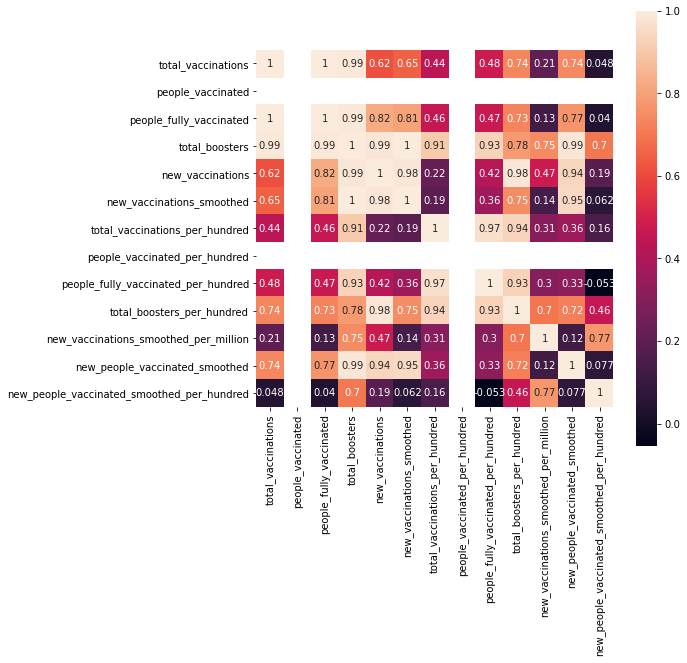

In [86]:
plt.subplots(figsize = (8, 8))
sns.heatmap(nan_df.corr(), annot = True, square = True)
plt.show()

0.0


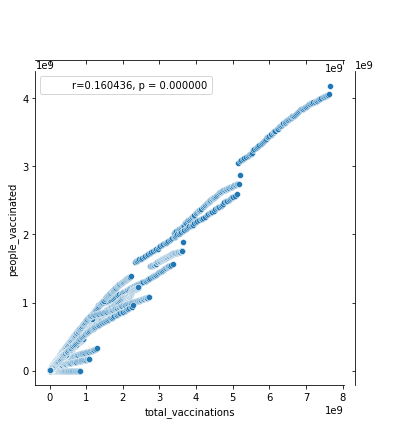

In [87]:
graph = sns.jointplot(data = covid_vaccine_df, x = 'total_vaccinations', y = 'people_vaccinated')
r, p = stats.pearsonr(covid_vaccine_df['total_vaccinations_per_hundred'], covid_vaccine_df['people_vaccinated'])
corr,  = graph.ax_joint.plot([], [], linestyle = "", alpha = 0)
graph.ax_joint.legend([corr], ['r={:f}, p = {:f}'.format(r, p)])

print(p)



With p-value < 0.05, we reject null hypothesis, so there is a significant difference between the two
This confirms it was ok for me to interpolate instead of deriving from another column

### data cleaning complete

# Visualization

## 1. How do the raw vaccinations look like?

Text(0.5, 0, 'Location')

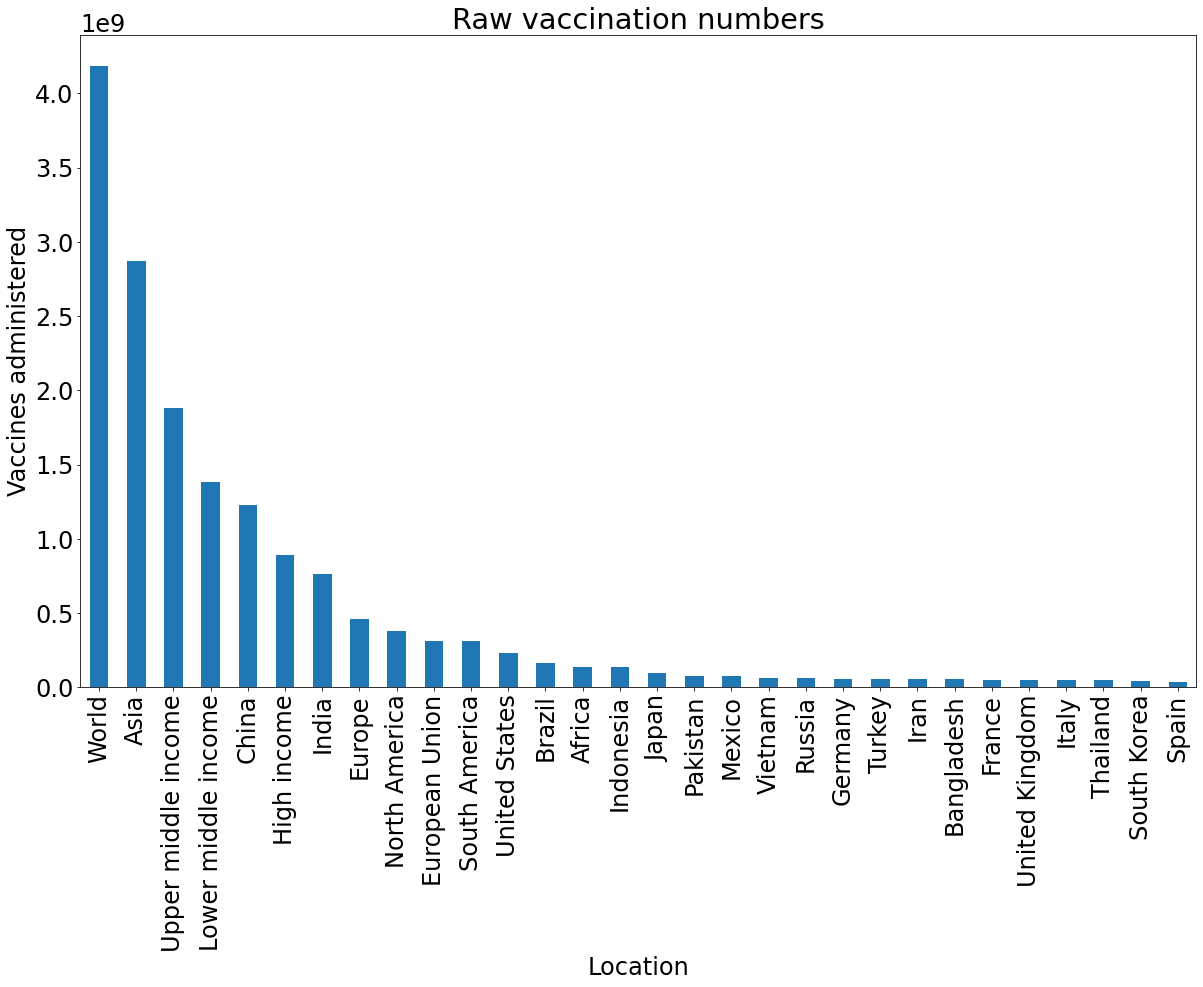

In [88]:
#Group data by country and sort data by max value
raw_total_vaccine = covid_vaccine_df.copy()
raw_total_vaccine = raw_total_vaccine.groupby('location').people_vaccinated.max().sort_values(ascending = False)

plt.figure(figsize = (20, 12))
plt.rcParams.update({'font.size': 24})
raw_total_vaccine[0:30].plot.bar()
plt.title("Raw vaccination numbers")
plt.ylabel("Vaccines administered")
plt.xlabel("Location")

## 2. How do the vaccinations look like as per 100 people?

Text(0.5, 0, 'Location')

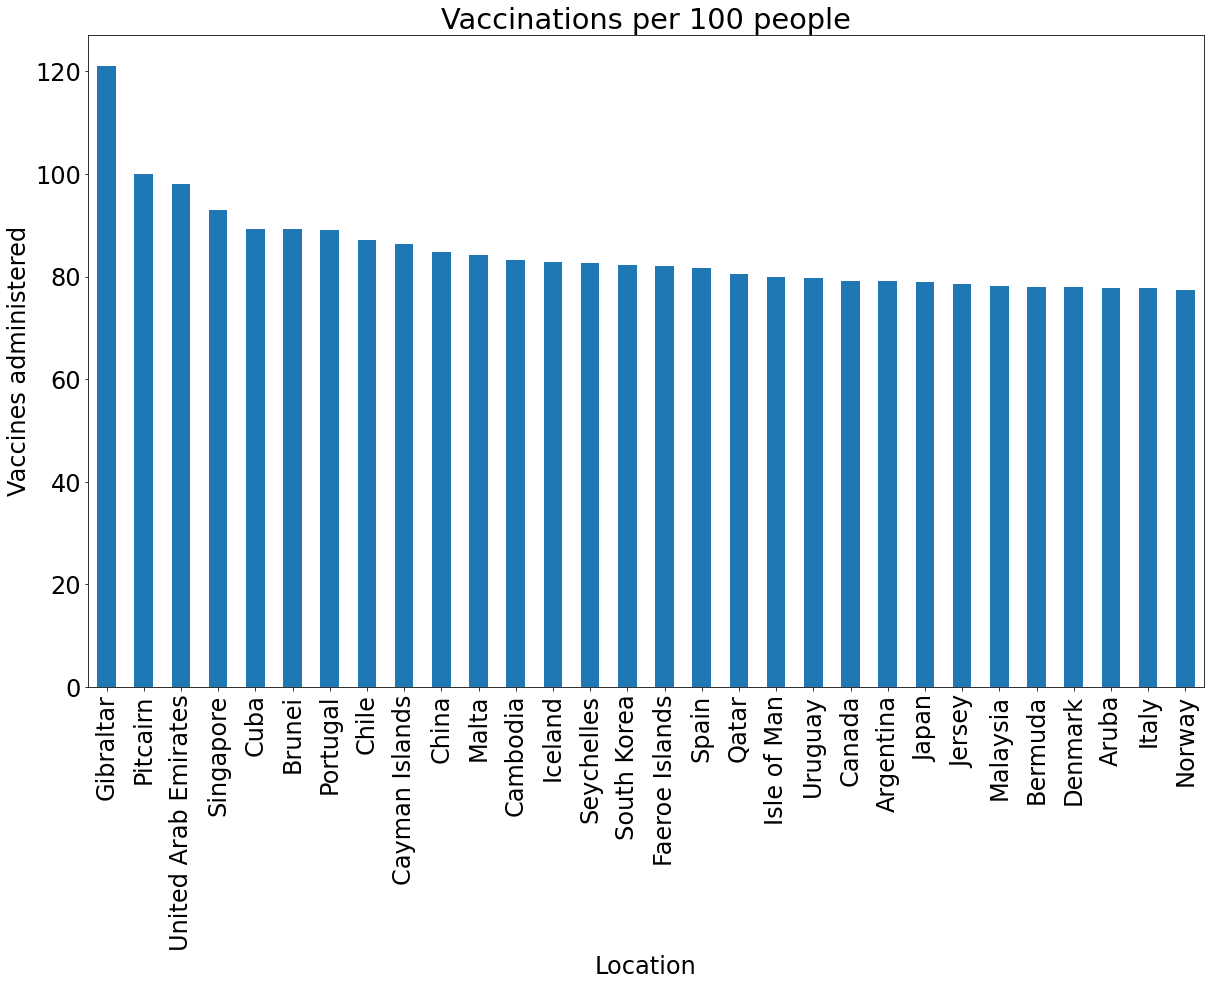

In [89]:
total_vaccine_hundred = covid_vaccine_df.copy()
total_vaccine_hundred = total_vaccine_hundred.groupby('location').people_vaccinated_per_hundred.max().sort_values(ascending = False)

plt.figure(figsize = (20, 12))
plt.rcParams.update({'font.size': 24})
total_vaccine_hundred[0:30].plot.bar()
plt.title("Vaccinations per 100 people")
plt.ylabel("Vaccines administered")
plt.xlabel("Location")

## 3. How do booster rates look like per 100 people?

Text(0.5, 0, 'Location')

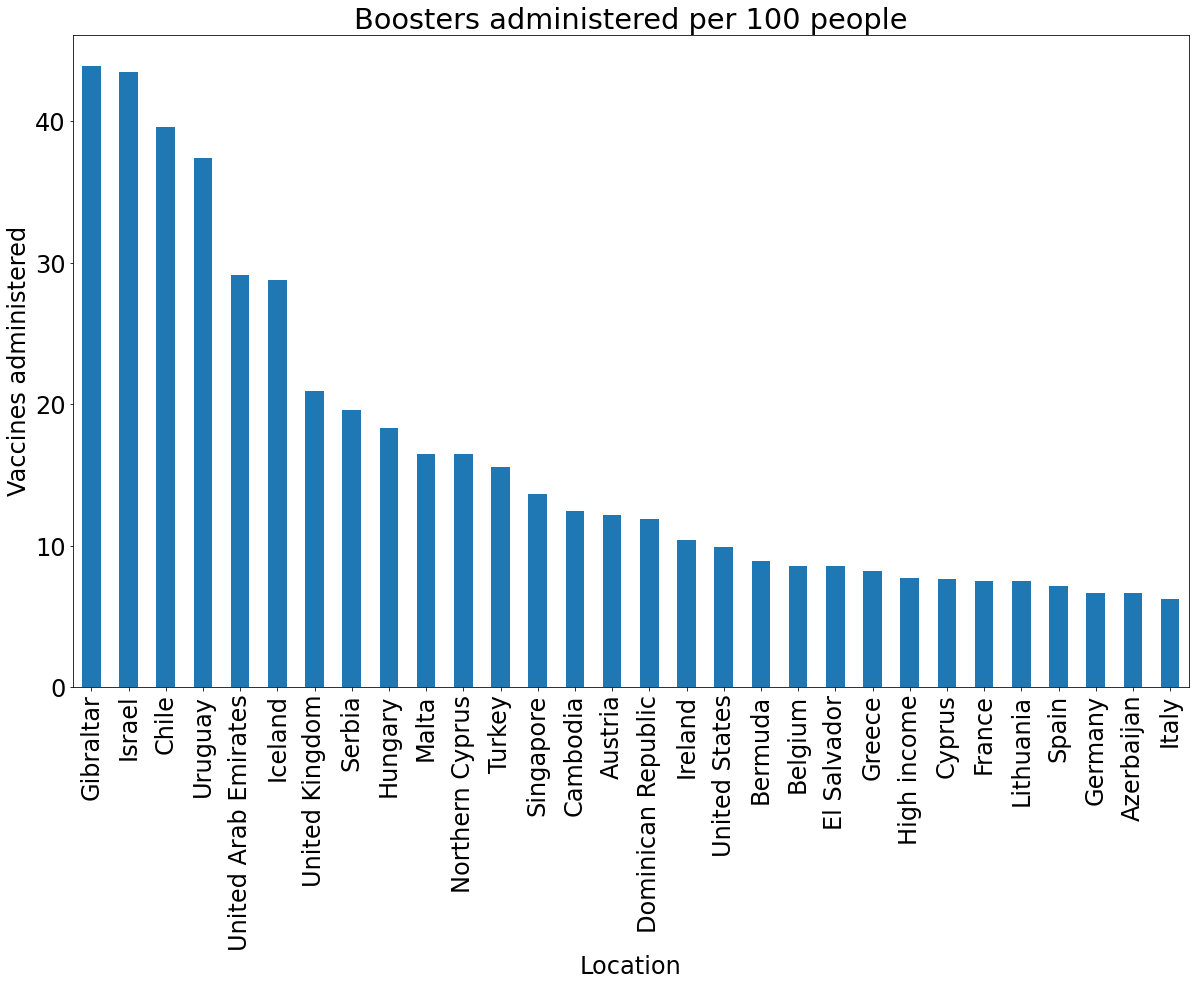

In [90]:
total_booster_hundred = covid_vaccine_df.copy()
total_booster_hundred = total_booster_hundred.groupby('location').total_boosters_per_hundred.max().sort_values(ascending = False)

plt.figure(figsize = (20, 12))
plt.rcParams.update({'font.size': 24})
total_booster_hundred[0:30].plot.bar()
plt.title("Boosters administered per 100 people")
plt.ylabel("Vaccines administered")
plt.xlabel("Location")

## 4. How do the fully vaccination rates look like?

Text(0.5, 0, 'Location')

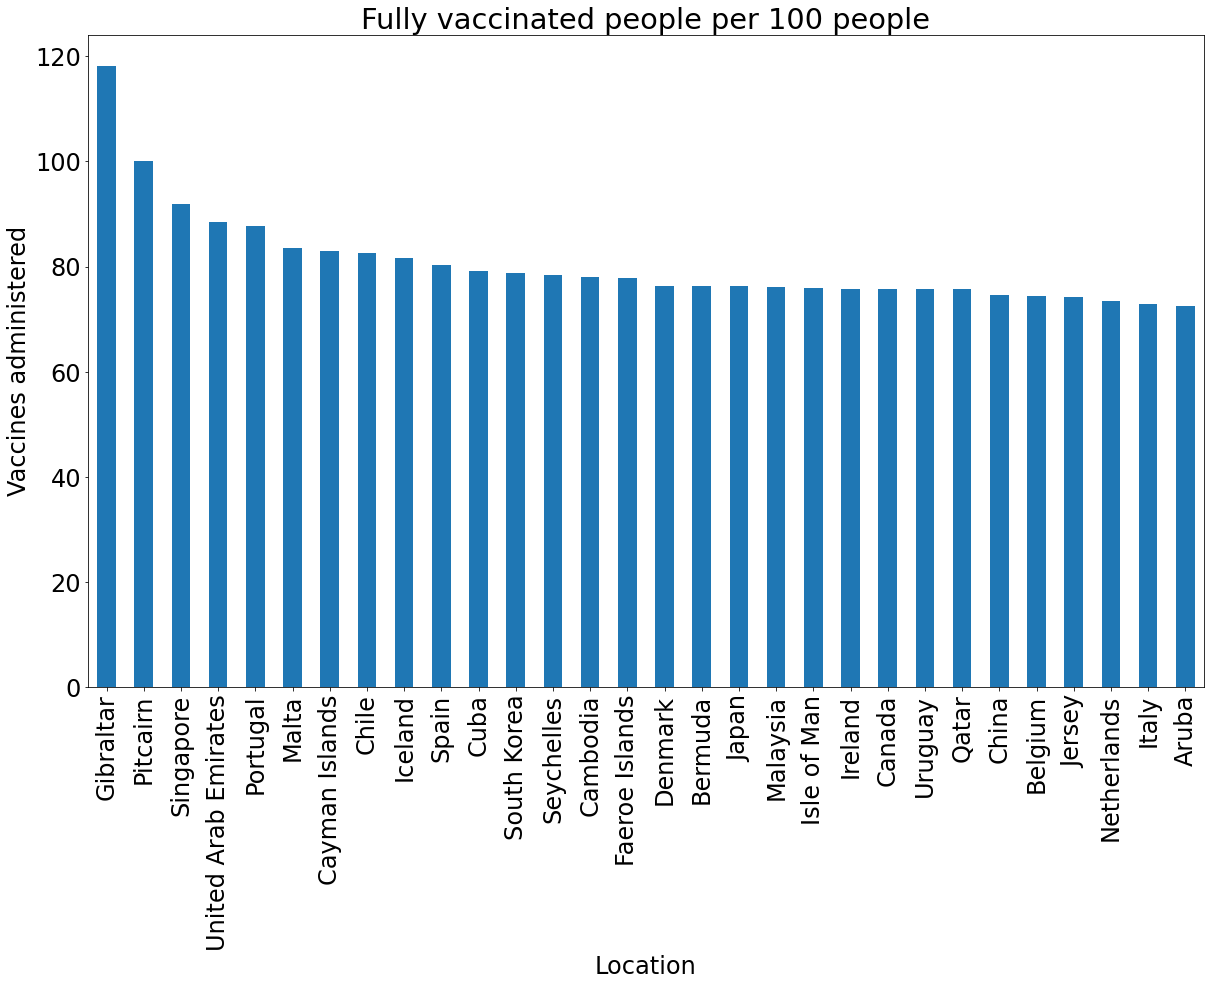

In [91]:
fully_vaccinated_hundred = covid_vaccine_df.copy()
fully_vaccinated_hundred = fully_vaccinated_hundred.groupby('location').people_fully_vaccinated_per_hundred.max().sort_values(ascending = False)

plt.figure(figsize = (20, 12))
plt.rcParams.update({'font.size': 24})
fully_vaccinated_hundred[0:30].plot.bar()
plt.title("Fully vaccinated people per 100 people")
plt.ylabel("Vaccines administered")
plt.xlabel("Location")

## Discussion

It appears that even though China, India, and the United States have the highest vaccination raw vaccination numbers, the scale in terms of per 100 people changes the graphs entirely. Gibraltar, for example, was noted to have more than 100 vaccines administered per 100 people. This implies booster shots. As shown in the booster plot, this confirms that Gibraltar has the highest booster rate. Given that the analysis has been focused on the US and Canada, the US may have more raw vaccination numbers than Canada, but on a per 100 people basis, Canada has a higher fully vaccinated rate than the US, evident in that the US is not even seen in the per-hundred-people charts. On the same vaccines-per-hundred-people chart, we can see Canada return to being among the top countries. However, on the boosters-per-hundred people, we can confirm that Gibraltar has the highest booter count, followed by Israel. We can also see from the booster plot that neither Canada nor the United States are as aggressive on delivering boosters.

## Isolating United States vaccination rates (for comparison to Canada)

In [92]:
usa_covid = covid_vaccine_df.copy()
usa_covid = usa_covid.loc[usa_covid['location'] == 'United States'].copy()

In [93]:
plt.rcParams.update({'font.size': 12})

<AxesSubplot:title={'center':'Americans vaccinated per hundred'}, xlabel='date', ylabel='People vaccinated per hundred'>

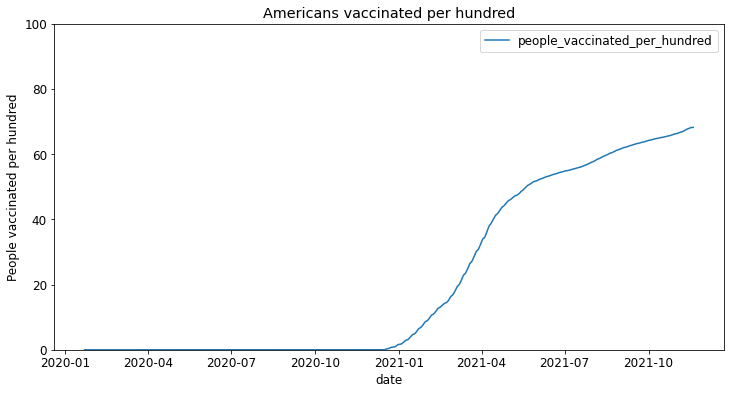

In [94]:
usa_covid.plot(x = 'date', y = 'people_vaccinated_per_hundred', title = 'Americans vaccinated per hundred', xlabel = 'date', ylabel = 'People vaccinated per hundred', ylim = (0, 100), figsize = (12, 6))

<AxesSubplot:title={'center':'Daily Americans vaccinated'}, xlabel='date', ylabel='new_people_vaccinated_per_hundred'>

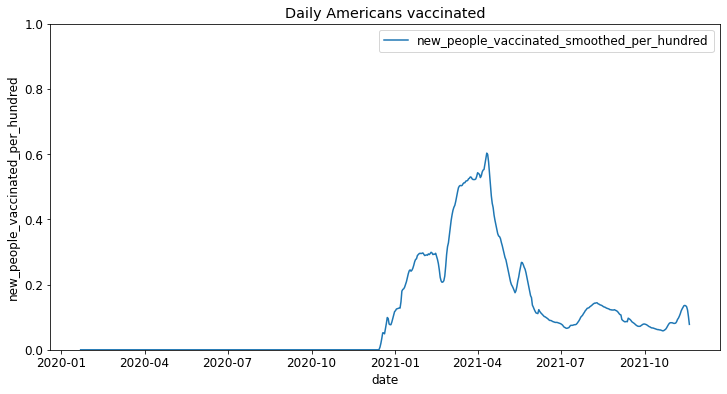

In [95]:
usa_covid.plot(x = 'date', y = 'new_people_vaccinated_smoothed_per_hundred', figsize = (12, 6), title = "Daily Americans vaccinated", xlabel = 'date', ylabel = 'new_people_vaccinated_per_hundred', ylim = (0, 1))

<AxesSubplot:title={'center':'Americans with boosters'}, xlabel='date', ylabel='boosters per hundred'>

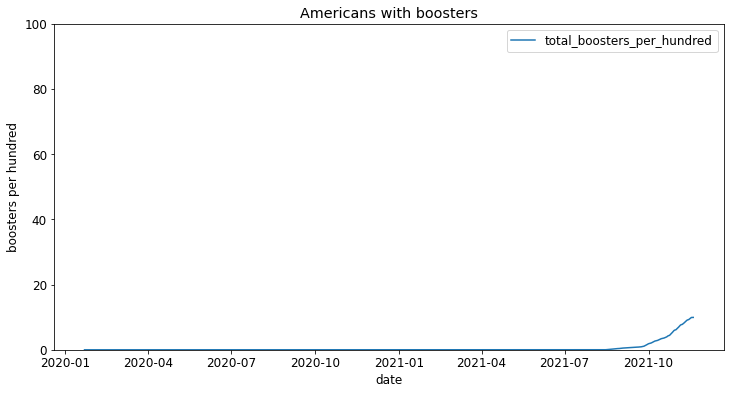

In [96]:
usa_covid.plot(x = 'date', y = 'total_boosters_per_hundred', figsize = (12, 6), title = "Americans with boosters", xlabel = 'date', ylabel = 'boosters per hundred', ylim = (0, 100))

<AxesSubplot:title={'center':'Americans fully vaccinated'}, xlabel='date', ylabel='Fully vaccinated per hundred'>

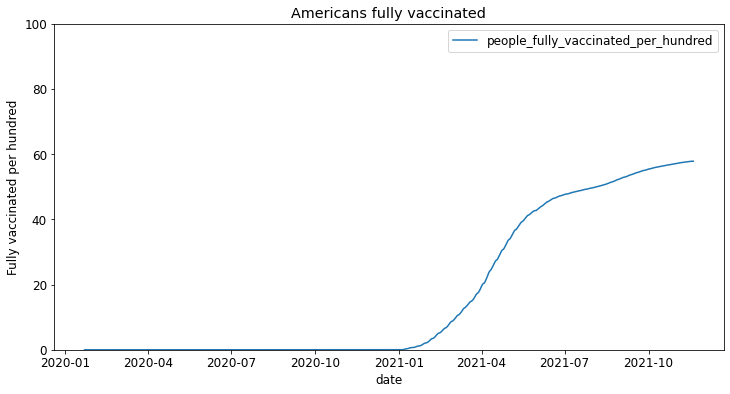

In [97]:
usa_covid.plot(x = 'date', y = 'people_fully_vaccinated_per_hundred', figsize = (12, 6), title = 'Americans fully vaccinated', xlabel = 'date', ylabel = 'Fully vaccinated per hundred', ylim = (0, 100))

## Isolating Canada for vaccination rates

<AxesSubplot:title={'center':'Canadians vaccinated per hundred'}, xlabel='date', ylabel='People vaccinated per hundred'>

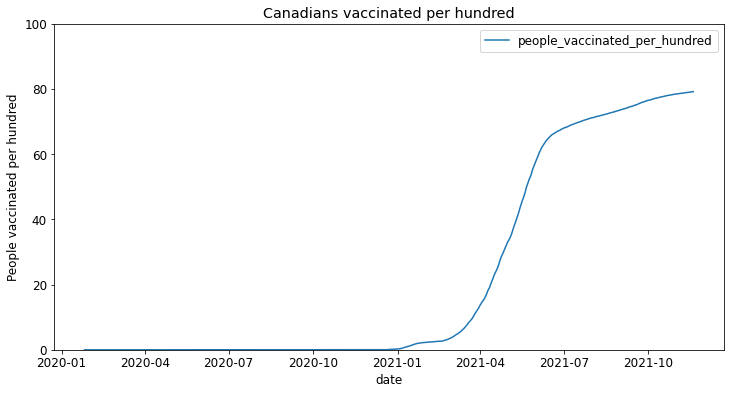

In [98]:
can_vaccine_df = covid_vaccine_df.loc[covid_vaccine_df['location'] =='Canada'].copy()
can_vaccine_df.plot(x = 'date', y = 'people_vaccinated_per_hundred', title = 'Canadians vaccinated per hundred', xlabel = 'date', ylabel = 'People vaccinated per hundred', ylim = (0, 100), figsize = (12, 6))

<AxesSubplot:title={'center':'Daily Canadians vaccianted'}, xlabel='date', ylabel='new_people_vaccinated_per_hundred'>

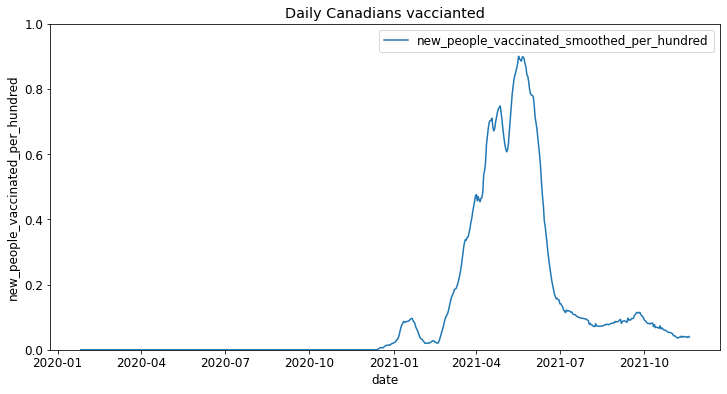

In [99]:
can_vaccine_df.plot(x = 'date', y = 'new_people_vaccinated_smoothed_per_hundred', figsize = (12, 6), title = 'Daily Canadians vaccianted', xlabel = 'date', ylabel = 'new_people_vaccinated_per_hundred', ylim = (0, 1))

<AxesSubplot:title={'center':'Canadians fully vaccinated per hundred'}, xlabel='date', ylabel='Fully vaccinated per hundred'>

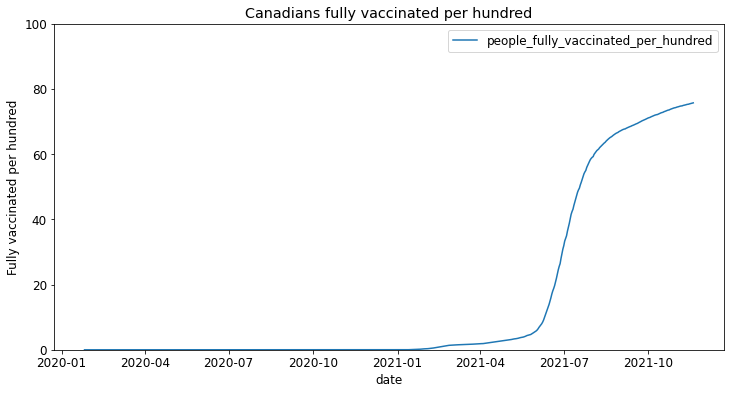

In [100]:
can_vaccine_df.plot(x = 'date', y = 'people_fully_vaccinated_per_hundred', figsize = (12, 6), title = 'Canadians fully vaccinated per hundred', xlabel = 'date', ylabel = 'Fully vaccinated per hundred', ylim = (0, 100))

<AxesSubplot:title={'center':'Canadians with boosters'}, xlabel='date', ylabel='boosters per hundred'>

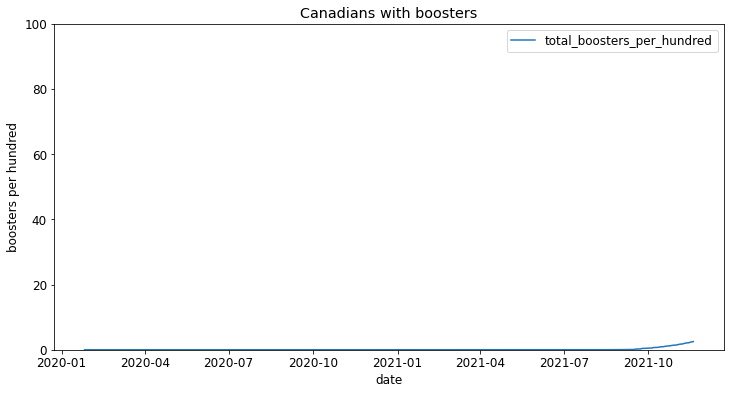

In [101]:
can_vaccine_df.plot(x = 'date', y = 'total_boosters_per_hundred', figsize = (12, 6), title = "Canadians with boosters", xlabel = 'date', ylabel = 'boosters per hundred', ylim = (0, 100))

## Discussion

These results confirm that even though the United States has a raw vaccination count higher than Canada, the per-hundred-people graphs show that Canada has a higher rate of vaccination for its population. Canada is approaching the 80% level in terms of fully vaccinated people, while the US is still struggling to reach 70%. However, the United States does have a higher booster rate per hundred people than Canada. Whether or not this will have difference in terms of hospitalizaiton rates will be seen llater. Now, the analysis will move towards the forecasting. 

# Model selection and fitting to data

The chosen model to pick will be ARIMA for forecasting both people_vaccinated_per_hundred, people_fully_vaccinated_per_hundred, and total_boosters_per_hundred for vaccination rates. I chose this model due to its abilitiy to automatically find optimal parameters. This has the potential to cut down on the model development time and may even find optimal parameters that I might not have found myself.

## Isolating for Canada - vaccinated per hundred

In [102]:
can_vaccine_df = covid_vaccine_df.loc[covid_vaccine_df['location'] =='Canada'].copy()

can_vaccinate_values = can_vaccine_df['people_vaccinated_per_hundred'].values

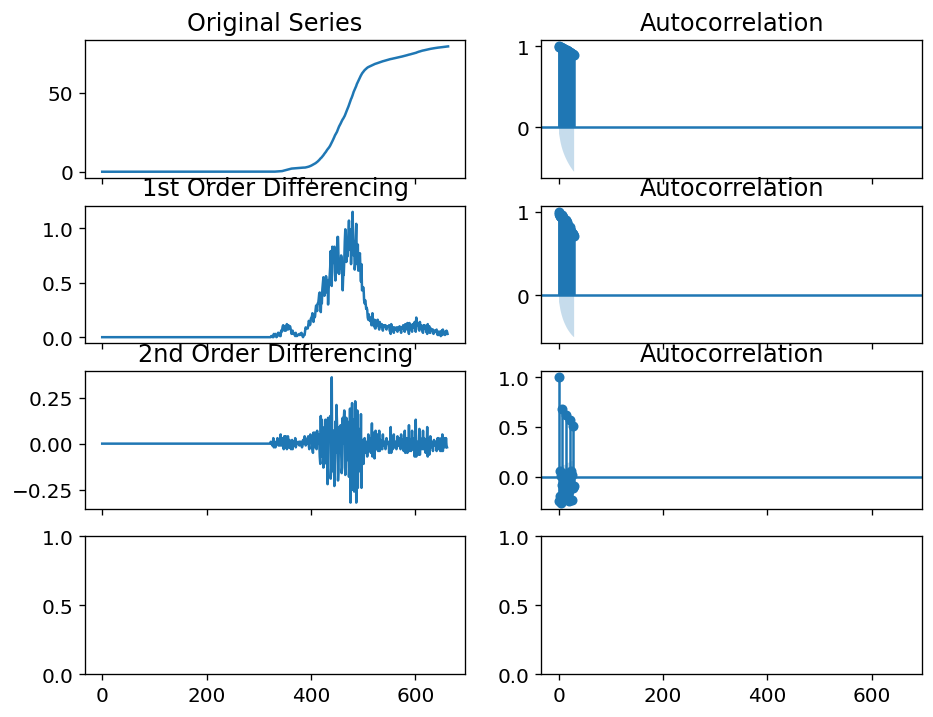

In [103]:
plt.rcParams.update({'figure.figsize': (9,7), 'figure.dpi': 120, 'font.size': 12}, )

#Original series
fig, axes = plt.subplots(4, 2, sharex = True)
axes[0, 0].plot(can_vaccinate_values); axes[0, 0].set_title('Original Series')
plot_acf(can_vaccinate_values, ax = axes[0,1])

#1st Differencing
axes[1, 0].plot(np.diff(can_vaccinate_values)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(can_vaccinate_values), ax = axes[1, 1])

diffval = np.diff(can_vaccinate_values)

#2nd Differencing
axes[2, 0].plot(np.diff(diffval)); axes[2,0].set_title("2nd Order Differencing")
plot_acf(np.diff(diffval), ax = axes[2, 1])
plt.show()

diffval2 = np.diff(diffval)

#3rd differencing
axes[3,0].plot(np.diff(diffval2)); axes[3, 0].set_title("3rd order differencing")
plot_acf(np.diff(diffval2), ax = axes[3, 1])
plt.show()

## Notes
Looks like to do 2nd order differencing? May want to experiment with parameters. The 2nd order differencing is a bit concerning given not all the points are within the threshold.

In [104]:
can_vaccine_model = pm.auto_arima(can_vaccinate_values, 
                                 start_p = 1, 
                                 start_q = 1,
                                 test = 'adf',
                                 max_p = 10,
                                 max_q = 10,
                                 m = 1,
                                 d = None,
                                 seasonal = False,
                                 start_P = 0,
                                 D = 0,
                                 trace = True,
                                 error_action = 'ignore',
                                 suppress_warnings = True,
                                 stepwise = True)
print(can_vaccine_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-2053.620, Time=0.51 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-1946.291, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-1987.120, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-2032.372, Time=0.27 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-1948.290, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-2059.833, Time=0.48 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-2036.297, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-2057.878, Time=0.72 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-2058.183, Time=0.63 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-2060.203, Time=0.35 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-2061.017, Time=0.44 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-2060.287, Time=0.58 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-2071.517, Time=0.73 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-2137.801, Time=1.00 sec
 ARIMA(3,2,3)(0,0,0

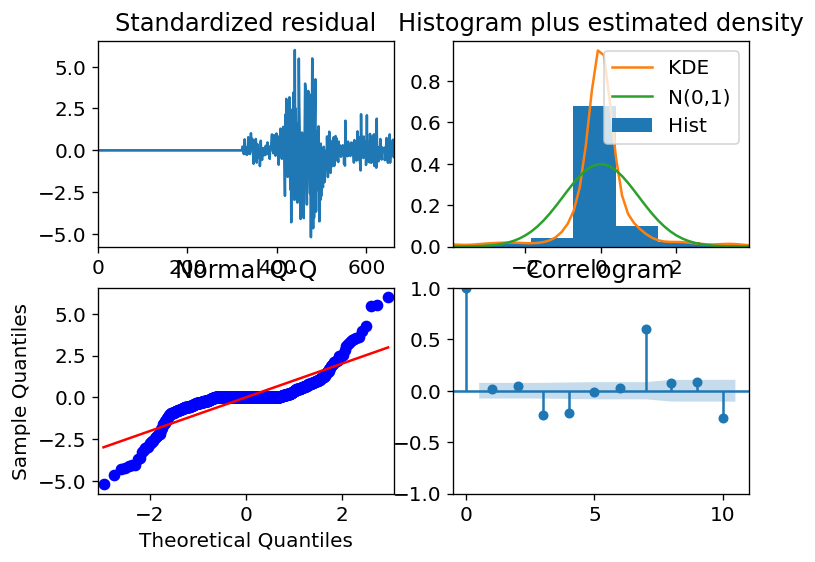

In [105]:
can_vaccine_model.plot_diagnostics(figsize = (7,5))
plt.show()

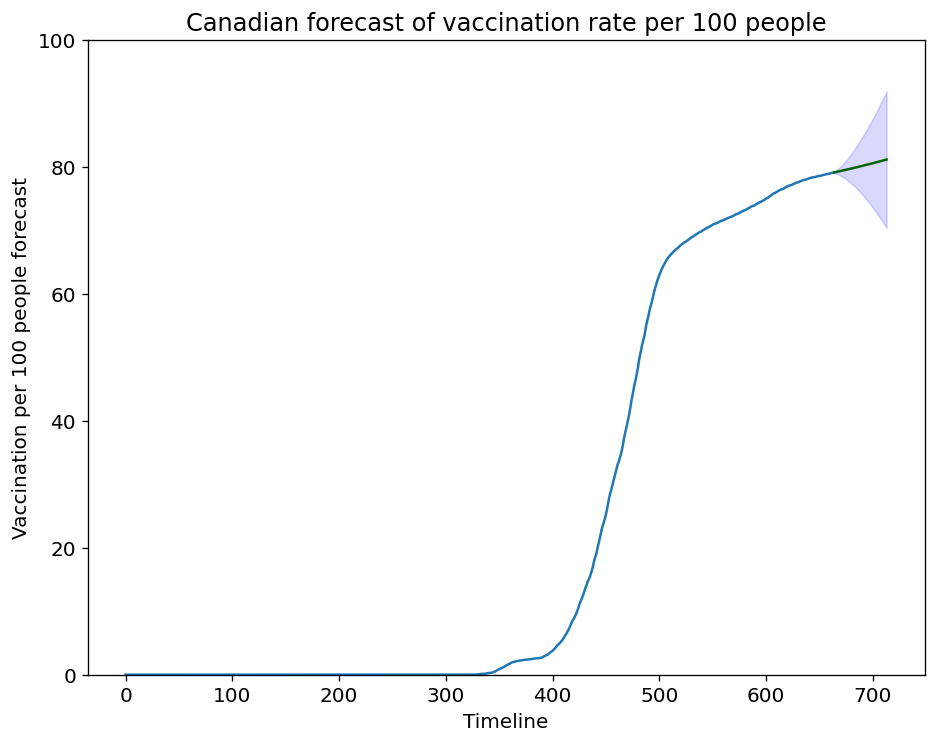

In [106]:
#Forecast
n_periods = 50
forecast, conf_int = can_vaccine_model.predict(n_periods = n_periods, return_conf_int = True)
index_of_forecast = np.arange(len(can_vaccinate_values), len(can_vaccinate_values) + n_periods)

#make series for plotting purposes
forecast_series = pd.Series(forecast, index = index_of_forecast)
lower_series = pd.Series(conf_int[:, 0], index = index_of_forecast)
upper_series = pd.Series(conf_int[:, 1 ], index = index_of_forecast)

#plot
plt.plot(can_vaccinate_values)
plt.plot(forecast_series, color = 'darkgreen')
plt.ylim(top = 100, bottom = 0)
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'b', alpha = 0.15)
plt.title("Canadian forecast of vaccination rate per 100 people")
plt.xlabel('Timeline')
plt.ylabel('Vaccination per 100 people forecast')
plt.show()

## Isolating for Canada - people_fully_vaccinated_per_hundred

In [107]:
can_full_vaccine_values = can_vaccine_df['people_fully_vaccinated_per_hundred'].values

In [108]:
can_full_vaccine_model = pm.auto_arima(can_full_vaccine_values,
                                       start_p = 1,
                                       start_1 = 1,
                                       test = 'adf',
                                       max_p = 10,
                                       max_q = 10,
                                       m = 1,
                                       d = None,
                                       seasonal = False,
                                       start_P = 0,
                                       D = 0,
                                       trace = True,
                                       error_action = 'ignore',
                                       suppress_warnings = True,
                                       stopwise = True)

print(can_full_vaccine_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-770.049, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6428.107, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-353.789, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1519.637, Time=0.52 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1571.395, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.87 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1572.786, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-352.486, Time=0.53 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARI

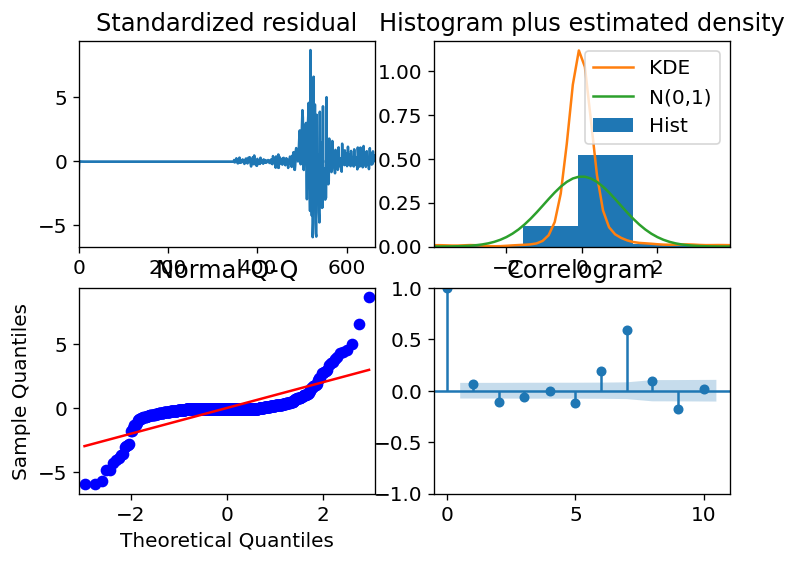

In [109]:
can_full_vaccine_model.plot_diagnostics(figsize = (7, 5))
plt.show()

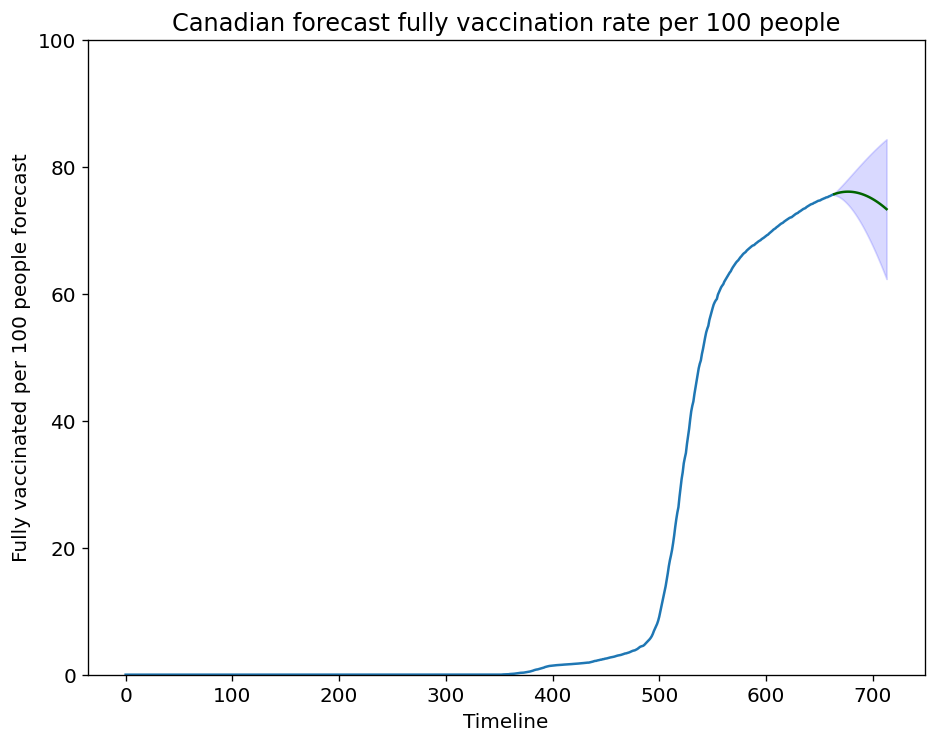

In [110]:
#Forecast
n_periods = 50
forecast, conf_int = can_full_vaccine_model.predict(n_periods = n_periods, return_conf_int = True)
index_of_forecast = np.arange(len(can_full_vaccine_values), len(can_full_vaccine_values) + n_periods)

#make series for plotting purposes
forecast_series = pd.Series(forecast, index = index_of_forecast)
lower_series = pd.Series(conf_int[:, 0], index = index_of_forecast)
upper_series = pd.Series(conf_int[:, 1 ], index = index_of_forecast)

#plot
plt.plot(can_full_vaccine_values)
plt.plot(forecast_series, color = 'darkgreen')
plt.ylim(top = 100, bottom = 0)
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'b', alpha = 0.15)
plt.title("Canadian forecast fully vaccination rate per 100 people")
plt.xlabel('Timeline')
plt.ylabel('Fully vaccinated per 100 people forecast')
plt.show()

## Isolating for Canada - total_boosters_per_hundred

In [111]:
can_boost_vaccine_values = can_vaccine_df['total_boosters_per_hundred'].values

In [112]:
can_boost_vaccine_model = pm.auto_arima(can_boost_vaccine_values,
                                       start_p = 1,
                                       start_1 = 1,
                                       test = 'adf',
                                       max_p = 10,
                                       max_q = 10,
                                       m = 1,
                                       d = None,
                                       seasonal = False,
                                       start_P = 0,
                                       D = 0,
                                       trace = True,
                                       error_action = 'ignore',
                                       suppress_warnings = True,
                                       stopwise = True)

print(can_boost_vaccine_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-4162.746, Time=0.62 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-3781.220, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-3881.916, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-4154.449, Time=0.33 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-3783.192, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-4153.306, Time=0.55 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-4152.928, Time=0.50 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-4170.984, Time=0.75 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-4182.731, Time=0.70 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-3993.262, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-4182.285, Time=0.98 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-4018.712, Time=0.23 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-4175.246, Time=0.89 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-4180.253, Time=0.34 sec

Best model:  ARIMA

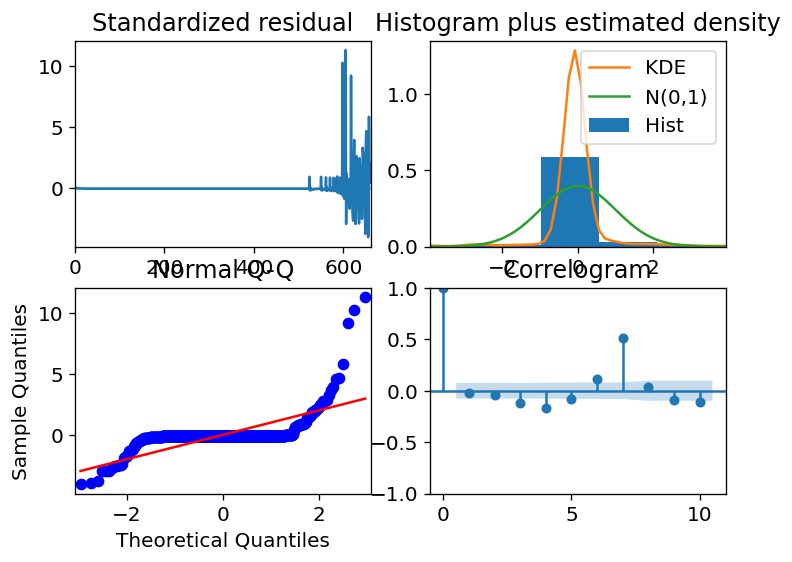

In [113]:
can_boost_vaccine_model.plot_diagnostics(figsize = (7, 5))
plt.show()

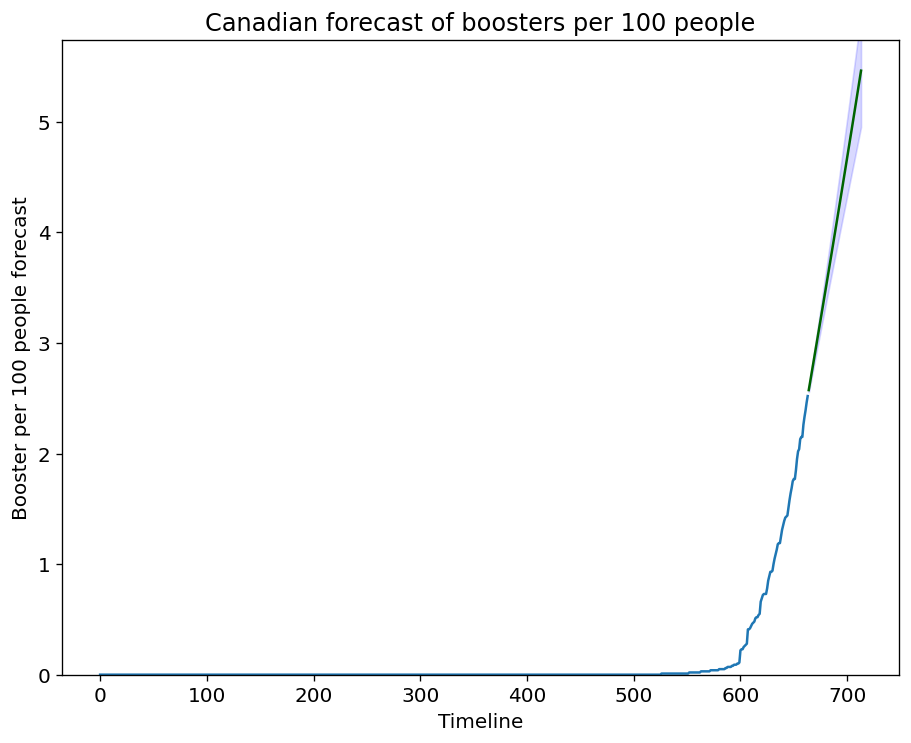

In [114]:
n_periods = 50
forecast, conf_int = can_boost_vaccine_model.predict(n_periods = n_periods, return_conf_int = True)
index_of_forecast = np.arange(len(can_boost_vaccine_values), len(can_boost_vaccine_values) + n_periods)

#make series for plotting purposes
forecast_series = pd.Series(forecast, index = index_of_forecast)
lower_series = pd.Series(conf_int[:, 0], index = index_of_forecast)
upper_series = pd.Series(conf_int[:, 1 ], index = index_of_forecast)

#plot
plt.plot(can_boost_vaccine_values)
plt.plot(forecast_series, color = 'darkgreen')
plt.ylim(bottom = 0)
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'b', alpha = 0.15)
plt.title("Canadian forecast of boosters per 100 people")
plt.xlabel('Timeline')
plt.ylabel('Booster per 100 people forecast')
plt.show()

### Notes

This shows that the current booster program is not sufficient to get the boosted population up fast enough. Expansion of boostershots are needed to ensure a higher uptake of booster rates

## Isolating for United States - vaccination rate per hundred

In [115]:
usa_vaccine_df = covid_vaccine_df.loc[covid_vaccine_df['location'] == 'United States'].copy()
usa_vaccine_values = usa_vaccine_df['people_vaccinated_per_hundred'].values

In [116]:
usa_vaccine_model = pm.auto_arima(usa_vaccine_values,
                                 start_p = 1,
                                 start_q = 1,
                                 test = 'adf',
                                 max_p = 10,
                                 max_q = 10,
                                 m = 1,
                                 d = None,
                                 seasonal = False,
                                 start_P = 0,
                                 D = 0,
                                 trace = True,
                                 error_action = 'ignore',
                                 suppress_warnings = True,
                                 stepwise = True)

print(usa_vaccine_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-1907.455, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-1837.572, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-1851.644, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-1869.723, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-1839.572, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-2105.969, Time=0.57 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-1933.160, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-2127.042, Time=0.66 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-1965.121, Time=0.06 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-2227.905, Time=0.72 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-2070.038, Time=0.35 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-2394.200, Time=0.91 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-2349.851, Time=0.87 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=-2638.898, Time=1.23 sec
 ARIMA(6,2,0)(0,0,0

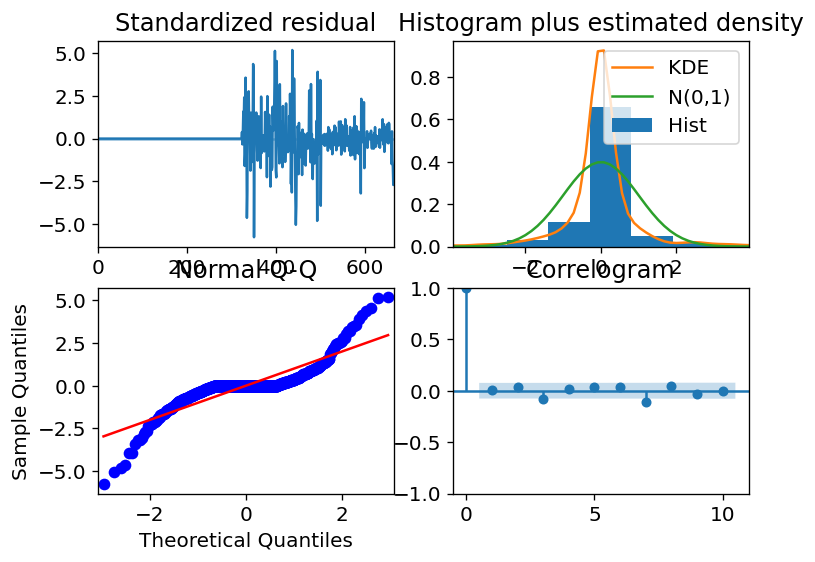

In [117]:
usa_vaccine_model.plot_diagnostics(figsize = (7, 5))
plt.show()

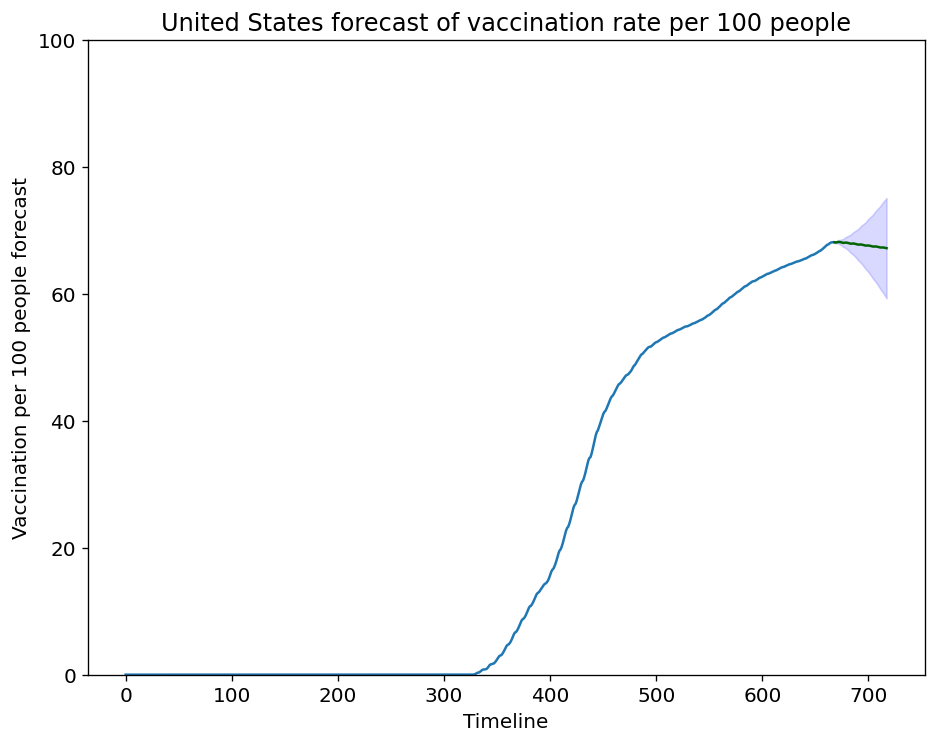

In [118]:
# Forecast 
n_periods = 50
forecast, conf_int = usa_vaccine_model.predict(n_periods = n_periods, return_conf_int = True)
index_of_forecast = np.arange(len(usa_vaccine_values), len(usa_vaccine_values) + n_periods)

#make series for plotting purposes
forecast_series = pd.Series(forecast, index = index_of_forecast)
lower_series = pd.Series(conf_int[:, 0], index = index_of_forecast)
upper_series = pd.Series(conf_int[:, 1 ], index = index_of_forecast)

#plot
plt.plot(usa_vaccine_values)
plt.plot(forecast_series, color = 'darkgreen')
plt.ylim(top = 100, bottom = 0)
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'b', alpha = 0.15)
plt.title("United States forecast of vaccination rate per 100 people")
plt.xlabel('Timeline')
plt.ylabel('Vaccination per 100 people forecast')
plt.show()

## Isolating for United States - people_fully_vaccinated_per_hundred

In [119]:
usa_full_vaccine_values = usa_vaccine_df['people_fully_vaccinated_per_hundred'].values

In [120]:
usa_full_vaccine_model = pm.auto_arima(usa_full_vaccine_values,
                                      start_p = 1,
                                      start_q = 1,
                                      test = 'adf',
                                      max_p = 10,
                                      max_q = 10,
                                      m = 1,
                                      d = None,
                                      seasonal = False,
                                      start_P = 0,
                                      D = 0,
                                      trace = True,
                                      error_action = 'ignore',
                                      suppress_warnings = True,
                                      stopwise = True)

print(usa_full_vaccine_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-2000.385, Time=0.39 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-1943.863, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-1951.378, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-1965.116, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-1945.863, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-2216.396, Time=1.22 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-2038.396, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-2232.438, Time=0.88 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-2060.263, Time=0.16 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-2347.773, Time=1.42 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-2157.049, Time=0.39 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-2562.316, Time=1.50 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-2497.706, Time=0.19 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=-2653.388, Time=2.16 sec
 ARIMA(6,2,0)(0,0,0

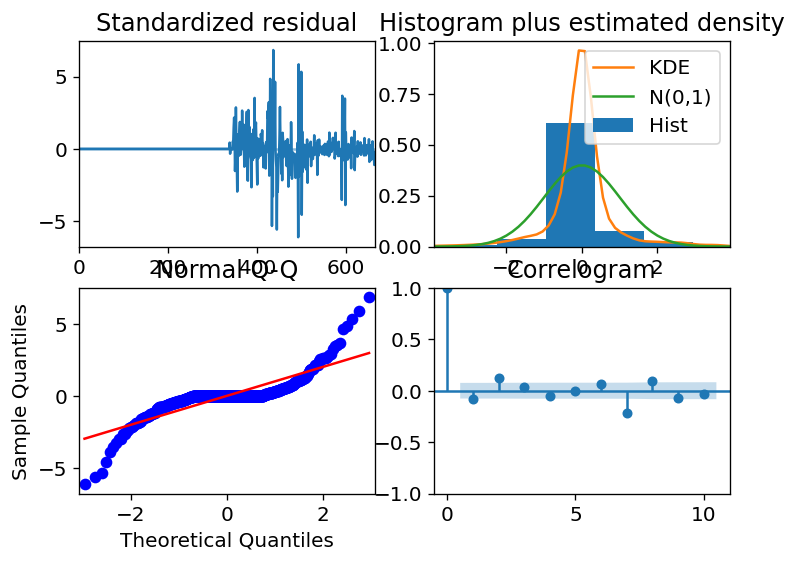

In [121]:
usa_full_vaccine_model.plot_diagnostics(figsize = (7, 5))
plt.show()

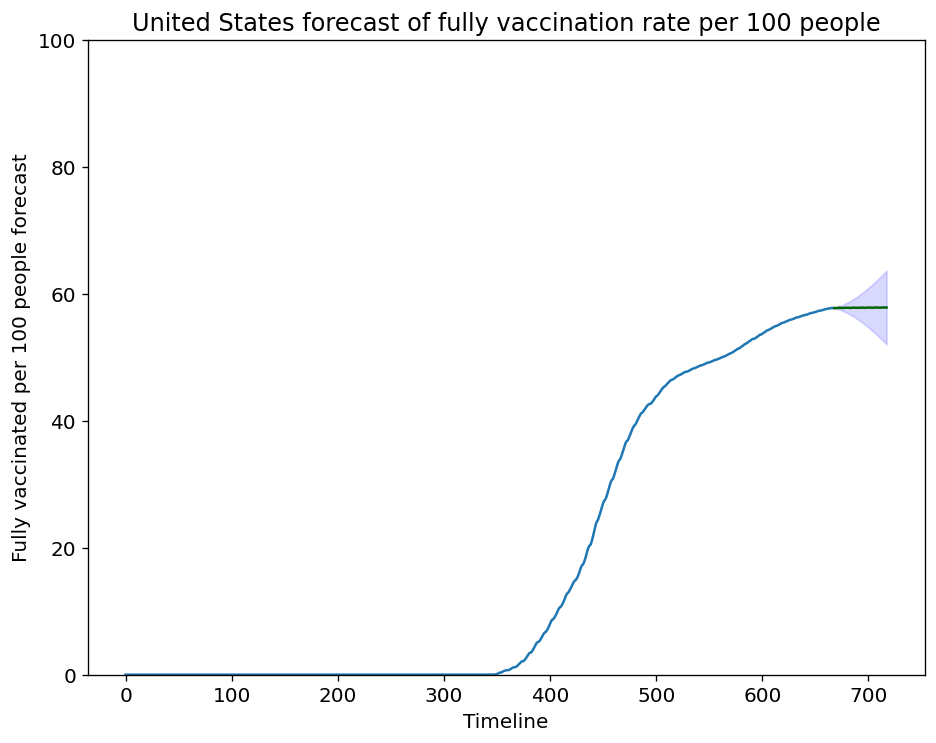

In [122]:
#Forecast 
n_periods = 50
forecast, conf_int = usa_full_vaccine_model.predict(n_periods = n_periods, return_conf_int = True)
index_of_forecast = np.arange(len(usa_full_vaccine_values), len(usa_full_vaccine_values) + n_periods)

#make series for plotting purposes
forecast_series = pd.Series(forecast, index = index_of_forecast)
lower_series = pd.Series(conf_int[:, 0], index = index_of_forecast)
upper_series = pd.Series(conf_int[:, 1 ], index = index_of_forecast)

#plot
plt.plot(usa_full_vaccine_values)
plt.plot(forecast_series, color = 'darkgreen')
plt.ylim(top = 100, bottom = 0)
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'b', alpha = 0.15)
plt.title("United States forecast of fully vaccination rate per 100 people")
plt.xlabel('Timeline')
plt.ylabel('Fully vaccinated per 100 people forecast')
plt.show()

## Isolating for United States - total_boosters_per_hundred

In [123]:
usa_boost_vaccine_values = usa_vaccine_df['total_boosters_per_hundred'].values

In [124]:
usa_boost_vaccine_model = pm.auto_arima(usa_boost_vaccine_values,
                                       start_p = 1,
                                       start_1 = 1,
                                       test = 'adf',
                                       max_p = 10,
                                       max_q = 10,
                                       m = 1,
                                       d = None,
                                       seasonal = False,
                                       start_P = 0,
                                       D = 0,
                                       trace = True,
                                       error_action = 'ignore',
                                       suppress_warnings = True,
                                       stopwise = True)

print(usa_boost_vaccine_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3313.903, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2069.958, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3167.398, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2762.848, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2017.653, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3021.202, Time=0.76 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3165.724, Time=0.47 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3333.956, Time=1.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3244.765, Time=1.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3310.368, Time=0.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-3308.444, Time=1.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3324.788, Time=1.53 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3300.779, Time=1.50 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-3412.099, Time=1.83 sec
 ARIMA(4,1,3)(0,0,0

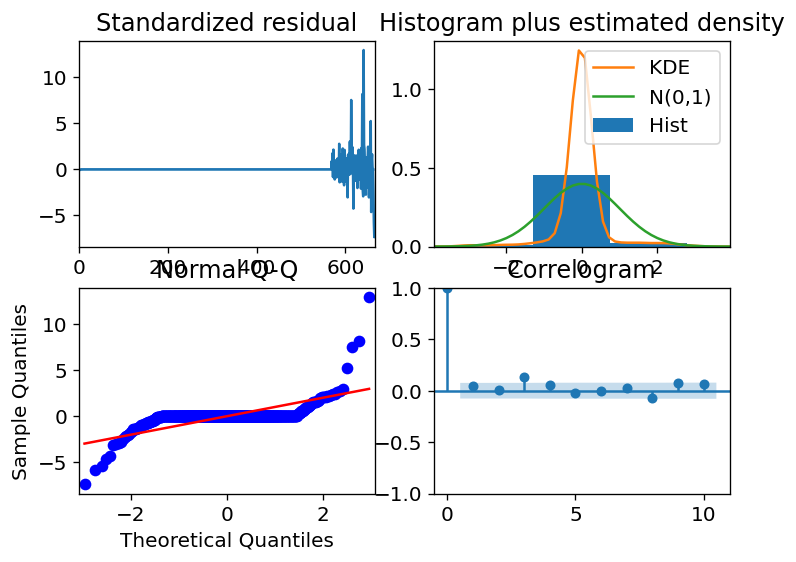

In [125]:
usa_boost_vaccine_model.plot_diagnostics(figsize = (7, 5))
plt.show()

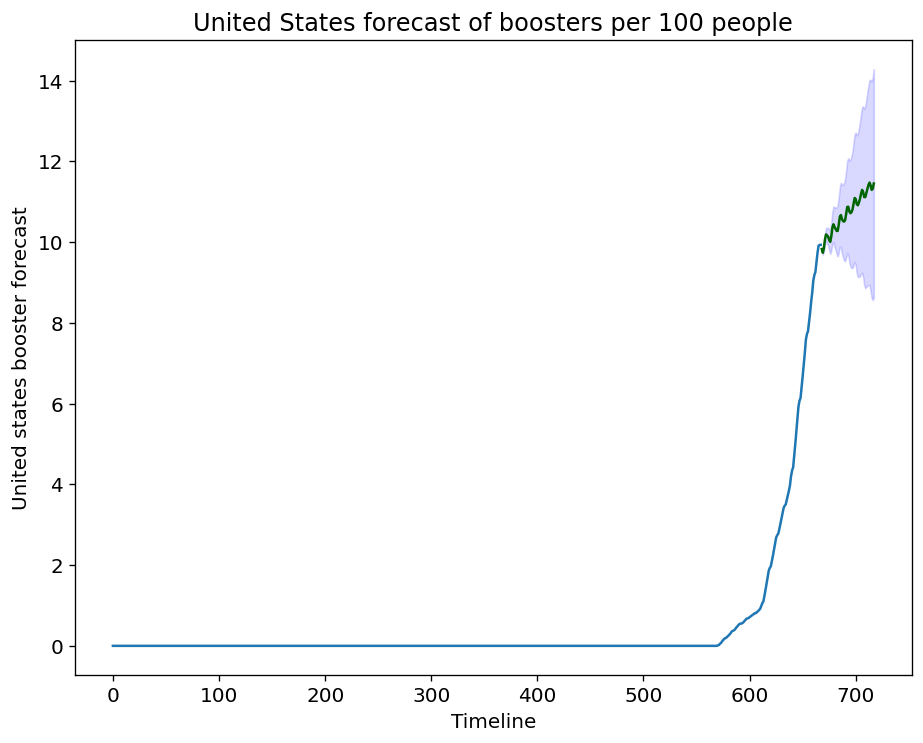

In [126]:
n_periods = 50
forecast, conf_int = usa_boost_vaccine_model.predict(n_periods = n_periods, return_conf_int = True)
index_of_forecast = np.arange(len(usa_boost_vaccine_values), len(usa_boost_vaccine_values) + n_periods)

#make series for plotting purposes
forecast_series = pd.Series(forecast, index = index_of_forecast)
lower_series = pd.Series(conf_int[:, 0], index = index_of_forecast)
upper_series = pd.Series(conf_int[:, 1 ], index = index_of_forecast)

#plot
plt.plot(usa_boost_vaccine_values)
plt.plot(forecast_series, color = 'darkgreen')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'b', alpha = 0.15)
plt.title("United States forecast of boosters per 100 people")
plt.xlabel('Timeline')
plt.ylabel('United states booster forecast')
plt.show()

## Discussion
It appears that the built-in model of auto-arima allows for a forecast for downward trend in vaccination rate. A downward slope in vaccination is not possible. From my perspective, this can mean that either the auto-arima package is not appropriate to perform forecasting on vaccination rates, or that there must be a parameter that prevents auto-arima from forecasting downward trends. Even with manual tuning of the different parameters, I could not get an improvement. Alternatively, the model might struggle with forecasting vaccination rates when the vaccination rates themselves flatline or remain stagnant. If I had to do this again, I would experiment with other models such as SIR, optimization, Monte Carlo simulation, or with a different ARIMA package altogether. 

Either way, the charts show that the forecasting booster rate for Canada is projected to be lower than that of the United States. With the rising concern of variants, Canada must consider rolling out its booster shots faster. The different significance plots shows that the model could not consistently remain within the significance region. Instead

# Relating COVID-19 Vaccination to Hospitalization rates

In [127]:
covid_hospital_df = covid_df[['iso_code', 'location', 'date', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million']].copy()

In [128]:
covid_hospital_df.isna().sum()

iso_code                                   0
location                                   0
date                                       0
total_deaths                           18574
new_deaths                             18378
new_deaths_smoothed                     8438
total_deaths_per_million               19213
new_deaths_per_million                 19017
new_deaths_smoothed_per_million         9085
icu_patients                          118315
icu_patients_per_million              118315
hosp_patients                         115535
hosp_patients_per_million             115535
weekly_icu_admissions                 133103
weekly_icu_admissions_per_million     133103
weekly_hosp_admissions                132305
weekly_hosp_admissions_per_million    132305
dtype: int64

In [129]:
covid_hospital_df.shape

(134459, 17)

In [130]:
covid_hospital_df.isna().sum()

iso_code                                   0
location                                   0
date                                       0
total_deaths                           18574
new_deaths                             18378
new_deaths_smoothed                     8438
total_deaths_per_million               19213
new_deaths_per_million                 19017
new_deaths_smoothed_per_million         9085
icu_patients                          118315
icu_patients_per_million              118315
hosp_patients                         115535
hosp_patients_per_million             115535
weekly_icu_admissions                 133103
weekly_icu_admissions_per_million     133103
weekly_hosp_admissions                132305
weekly_hosp_admissions_per_million    132305
dtype: int64

In [131]:
china_hospital_df = covid_hospital_df.loc[covid_hospital_df['location'] == 'China']

In [132]:
china_hospital_df

,iso_code,location,date,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million
24768,CHN,China,2020-01-22,17.0,NaN,NaN,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24769,CHN,China,2020-01-23,18.0,1.0,NaN,0.012,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24770,CHN,China,2020-01-24,26.0,8.0,NaN,0.018,0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24771,CHN,China,2020-01-25,42.0,16.0,NaN,0.029,0.011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24772,CHN,China,2020-01-26,56.0,14.0,NaN,0.039,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25431,CHN,China,2021-11-15,4636.0,0.0,0.0,3.210,0.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25432,CHN,China,2021-11-16,4636.0,0.0,0.0,3.210,0.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25433,CHN,China,2021-11-17,4636.0,0.0,0.0,3.210,0.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25434,CHN,China,2021-11-18,4636.0,0.0,0.0,3.210,0.000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preliminary visualizaiton of Canadian hospitalization rates

Just like what was done with the vaccination rates, preliminary exploring and experimenting will be done before a more formalized cleanup pipeline

In [133]:
canada_hospital_df = covid_hospital_df.loc[covid_hospital_df['location'] == 'Canada'].copy()

In [134]:
canada_hospital_df

,iso_code,location,date,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million
21310,CAN,Canada,2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21311,CAN,Canada,2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21312,CAN,Canada,2020-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21313,CAN,Canada,2020-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21314,CAN,Canada,2020-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21969,CAN,Canada,2021-11-15,29435.0,50.0,27.000,773.223,1.313,0.709,496.0,13.029,1590.0,41.767,NaN,NaN,NaN,NaN
21970,CAN,Canada,2021-11-16,29458.0,23.0,26.429,773.828,0.604,0.694,486.0,12.767,1762.0,46.286,NaN,NaN,NaN,NaN
21971,CAN,Canada,2021-11-17,29485.0,27.0,26.000,774.537,0.709,0.683,484.0,12.714,1731.0,45.471,NaN,NaN,NaN,NaN
21972,CAN,Canada,2021-11-18,29516.0,31.0,28.429,775.351,0.814,0.747,468.0,12.294,1699.0,44.631,NaN,NaN,NaN,NaN


In [135]:
len(canada_hospital_df)

664

In [136]:
canada_hospital_df.fillna(0)

,iso_code,location,date,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million
21310,CAN,Canada,2020-01-26,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0
21311,CAN,Canada,2020-01-27,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0
21312,CAN,Canada,2020-01-28,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0
21313,CAN,Canada,2020-01-29,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0
21314,CAN,Canada,2020-01-30,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21969,CAN,Canada,2021-11-15,29435.0,50.0,27.000,773.223,1.313,0.709,496.0,13.029,1590.0,41.767,0.0,0.0,0.0,0.0
21970,CAN,Canada,2021-11-16,29458.0,23.0,26.429,773.828,0.604,0.694,486.0,12.767,1762.0,46.286,0.0,0.0,0.0,0.0
21971,CAN,Canada,2021-11-17,29485.0,27.0,26.000,774.537,0.709,0.683,484.0,12.714,1731.0,45.471,0.0,0.0,0.0,0.0
21972,CAN,Canada,2021-11-18,29516.0,31.0,28.429,775.351,0.814,0.747,468.0,12.294,1699.0,44.631,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='date'>

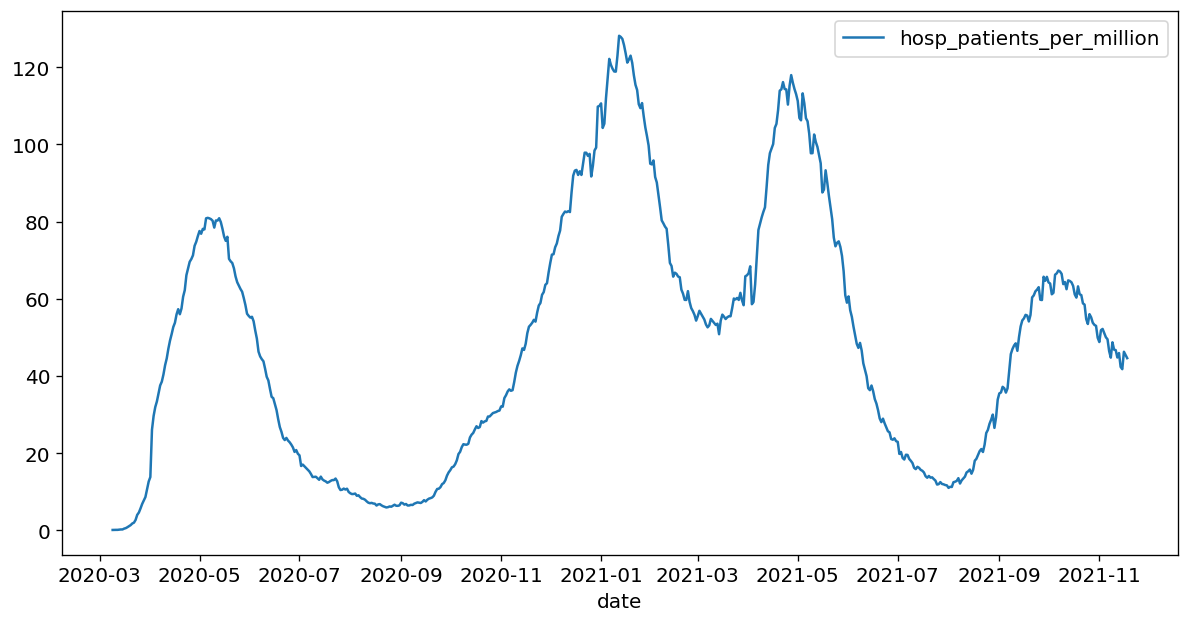

In [137]:
canada_hospital_df.plot(x = 'date', y = 'hosp_patients_per_million', figsize = (12, 6))

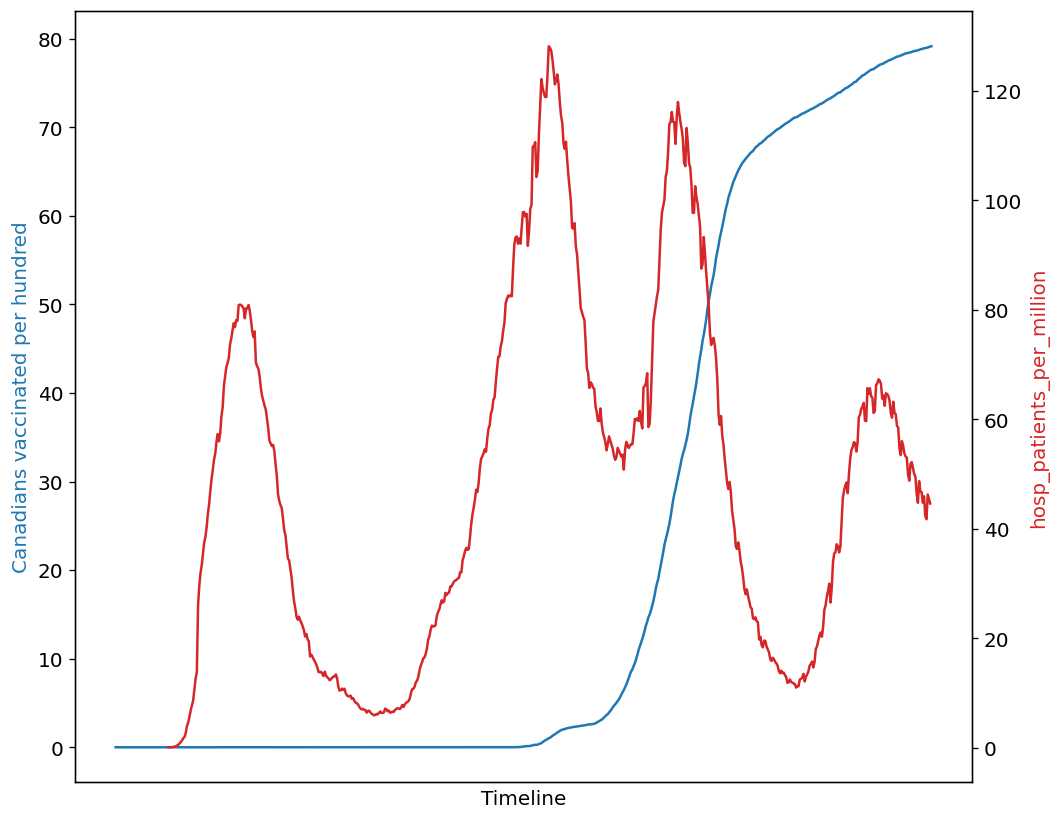

In [138]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Timeline')
ax1.set_ylabel('Canadians vaccinated per hundred', color = color)
ax1.plot(canada_covid_df['date'], canada_covid_df['people_vaccinated_per_hundred'], color = color)
ax1.tick_params(axis = 'x', which = 'minor', bottom = False)
get_ticks = ax1.get_xticklabels()

ax2 = ax1.twinx()

color2 = 'tab:red'
ax2.set_ylabel('hosp_patients_per_million', color = color2)
ax2.plot(canada_hospital_df['date'], canada_hospital_df['hosp_patients_per_million'], color = color2)
ax2.tick_params(axis = 'x', which = 'minor', bottom  = False)
ax2.set_xticks([], [])

fig.tight_layout()
plt.show()

## Notes
Charts work and cleanup makes an interpretable graph. It appears I can use the same methodology for interpolating and filling other NaN values with zeros like what I have done with the vaccination data. Time for a more formal cleanup pipeline

## Data cleanup for hospitalization rates

In [139]:
def country_interpolate_hospital(country, original_df, column_list):
    country_df = original_df.loc[original_df['location'] == country].copy()
    country_df_idx = country_df.index
    
    for column in column_list:
        interpolate_column = country_df[column].interpolate()
        country_df[column] = interpolate_column
    
    country_df = country_df.fillna(0)
    
    return country_df    

In [140]:
country_interpolate_hospital('China', covid_hospital_df, ['total_deaths', 'new_deaths',
       'new_deaths_smoothed',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million'])

,iso_code,location,date,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million
24768,CHN,China,2020-01-22,17.0,0.0,0.0,0.012,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24769,CHN,China,2020-01-23,18.0,1.0,0.0,0.012,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24770,CHN,China,2020-01-24,26.0,8.0,0.0,0.018,0.006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24771,CHN,China,2020-01-25,42.0,16.0,0.0,0.029,0.011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24772,CHN,China,2020-01-26,56.0,14.0,0.0,0.039,0.010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25431,CHN,China,2021-11-15,4636.0,0.0,0.0,3.210,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25432,CHN,China,2021-11-16,4636.0,0.0,0.0,3.210,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25433,CHN,China,2021-11-17,4636.0,0.0,0.0,3.210,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25434,CHN,China,2021-11-18,4636.0,0.0,0.0,3.210,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
country_interpolate_hospital('United States', covid_hospital_df, ['total_deaths', 'new_deaths',
       'new_deaths_smoothed',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million'])

,iso_code,location,date,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million
126892,USA,United States,2020-01-22,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.000
126893,USA,United States,2020-01-23,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.000
126894,USA,United States,2020-01-24,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.000
126895,USA,United States,2020-01-25,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.000
126896,USA,United States,2020-01-26,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127555,USA,United States,2021-11-15,764533.0,1271.0,1165.286,2296.481,3.818,3.500,11544.0,34.676,43268.0,129.967,0.0,0.0,38161.0,114.627
127556,USA,United States,2021-11-16,765811.0,1278.0,1142.714,2300.319,3.839,3.432,11561.0,34.727,43740.0,131.385,0.0,0.0,38161.0,114.627
127557,USA,United States,2021-11-17,767433.0,1622.0,1141.286,2305.192,4.872,3.428,11573.0,34.763,44131.0,132.559,0.0,0.0,38161.0,114.627
127558,USA,United States,2021-11-18,768695.0,1262.0,1212.714,2308.982,3.791,3.643,11315.0,33.988,43242.0,129.889,0.0,0.0,38161.0,114.627


In [142]:
for country in covid_hospital_df['location'].unique():
    covid_hospital_df.update(country_interpolate_hospital(country, covid_hospital_df, ['total_deaths', 'new_deaths',
       'new_deaths_smoothed',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million']))

## Notes
Data cleanup complete

# Isolating hospitalization rates for US and Canada and visualizing vaccination vs hospitalization 

In [143]:
canada_hospital_df = covid_hospital_df[covid_hospital_df['location'] == 'Canada'].copy()

In [144]:
canada_hospital_df.head()

,iso_code,location,date,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million
21310,CAN,Canada,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21311,CAN,Canada,2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21312,CAN,Canada,2020-01-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21313,CAN,Canada,2020-01-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21314,CAN,Canada,2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [145]:
canada_covid_df.head()

,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,total_boosters_per_Hundred
0,2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


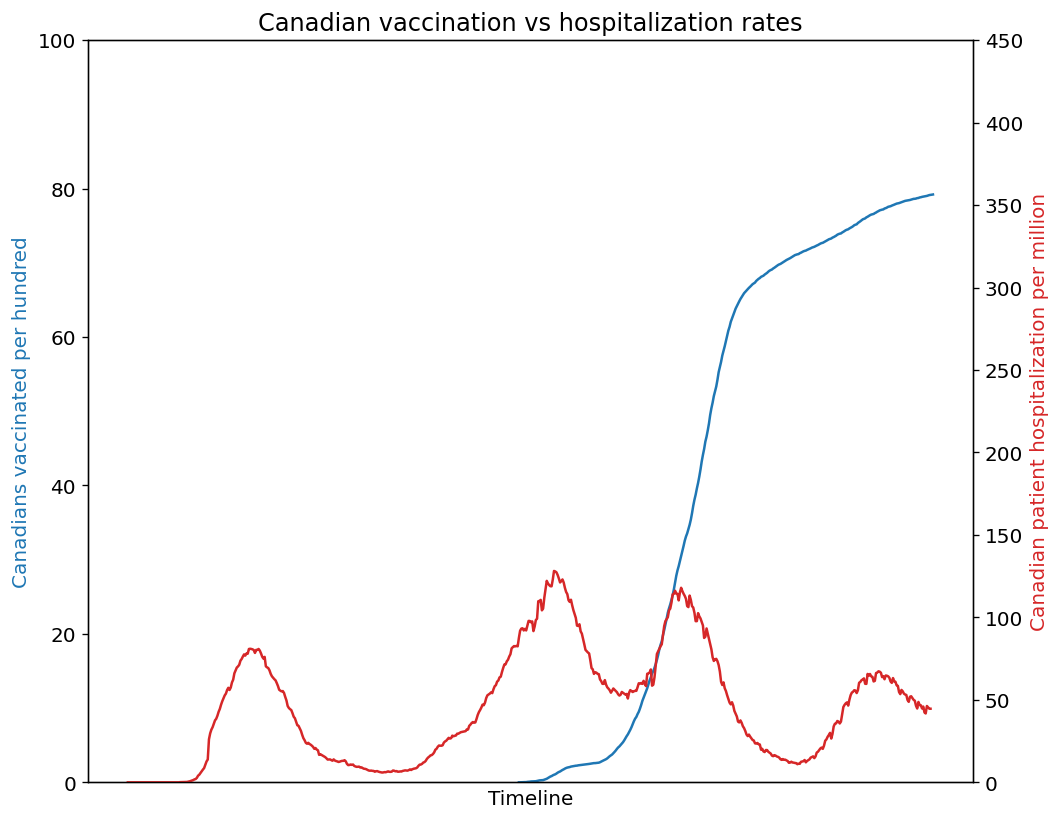

In [146]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_title("Canadian vaccination vs hospitalization rates")
ax1.set_xlabel('Timeline')
ax1.set_ylabel('Canadians vaccinated per hundred', color = color)
ax1.set_ylim(bottom = 0, top = 100)
ax1.plot(canada_vaccine_df['date'], canada_vaccine_df['people_vaccinated_per_hundred'], color = color)
ax1.tick_params(axis = 'x', which = 'minor', bottom = False)

ax2 = ax1.twinx()

color2 = 'tab:red'
ax2.set_ylabel('Canadian patient hospitalization per million', color = color2)
ax2.plot(canada_hospital_df['date'], canada_hospital_df['hosp_patients_per_million'], color = color2)
ax2.tick_params(axis = 'x', which = 'minor', bottom = False)
ax2.set_ylim(bottom = 0, top = 450)
ax2.set_xticks([], [])


fig.tight_layout()
plt.show()



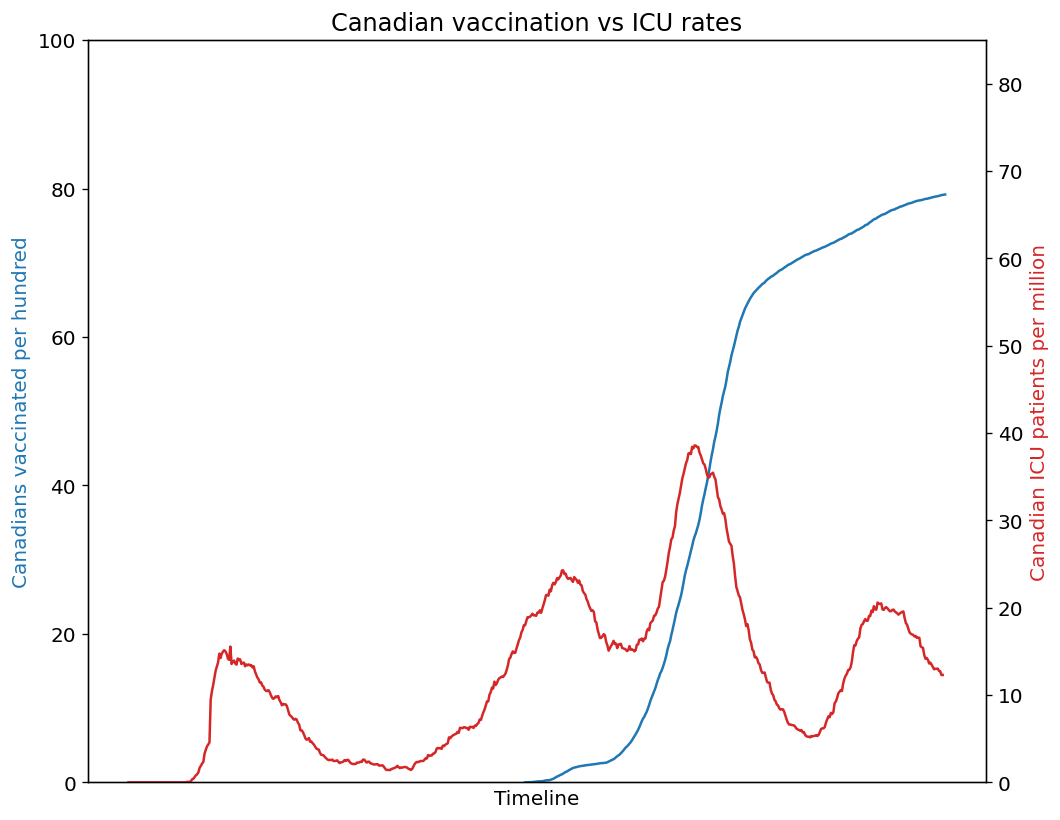

In [147]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_title("Canadian vaccination vs ICU rates")
ax1.set_xlabel('Timeline')
ax1.set_ylabel('Canadians vaccinated per hundred', color = color)
ax1.set_ylim(bottom = 0, top = 100)
ax1.plot(canada_vaccine_df['date'], canada_vaccine_df['people_vaccinated_per_hundred'], color = color)
ax1.tick_params(axis = 'x', which = 'minor', bottom = False)

ax2 = ax1.twinx()

color2 = 'tab:red'
ax2.set_ylabel('Canadian ICU patients per million', color = color2)
ax2.plot(canada_hospital_df['date'], canada_hospital_df['icu_patients_per_million'], color = color2)
ax2.tick_params(axis = 'x', which = 'minor', bottom = False)
ax2.set_ylim(bottom = 0, top = 85)
ax2.set_xticks([], [])


fig.tight_layout()
plt.show()

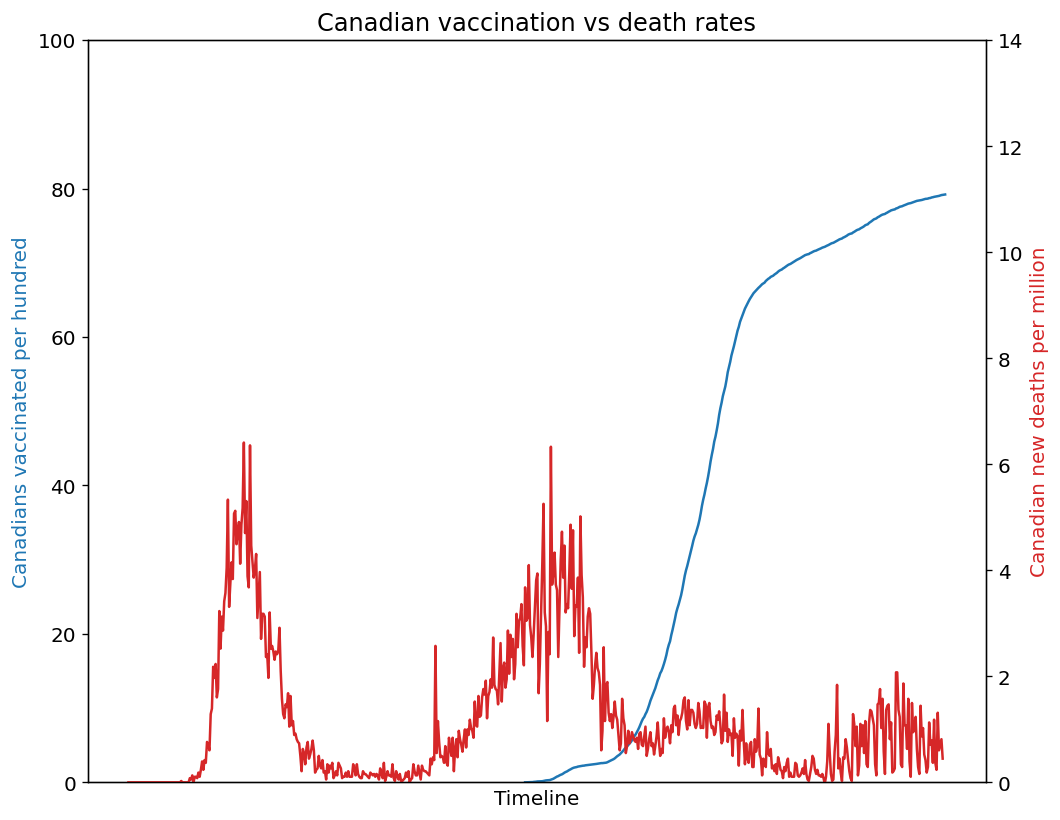

In [148]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_title("Canadian vaccination vs death rates")
ax1.set_xlabel('Timeline')
ax1.set_ylabel('Canadians vaccinated per hundred', color = color)
ax1.set_ylim(bottom = 0, top = 100)
ax1.plot(canada_vaccine_df['date'], canada_vaccine_df['people_vaccinated_per_hundred'], color = color)
ax1.tick_params(axis = 'x', which = 'minor', bottom = False)

ax2 = ax1.twinx()

color2 = 'tab:red'
ax2.set_ylabel('Canadian new deaths per million', color = color2)
ax2.plot(canada_hospital_df['date'], canada_hospital_df['new_deaths_per_million'], color = color2)
ax2.tick_params(axis = 'x', which = 'minor', bottom = False)
ax2.set_ylim(bottom = 0, top = 14)
ax2.set_xticks([], [])


fig.tight_layout()
plt.show()

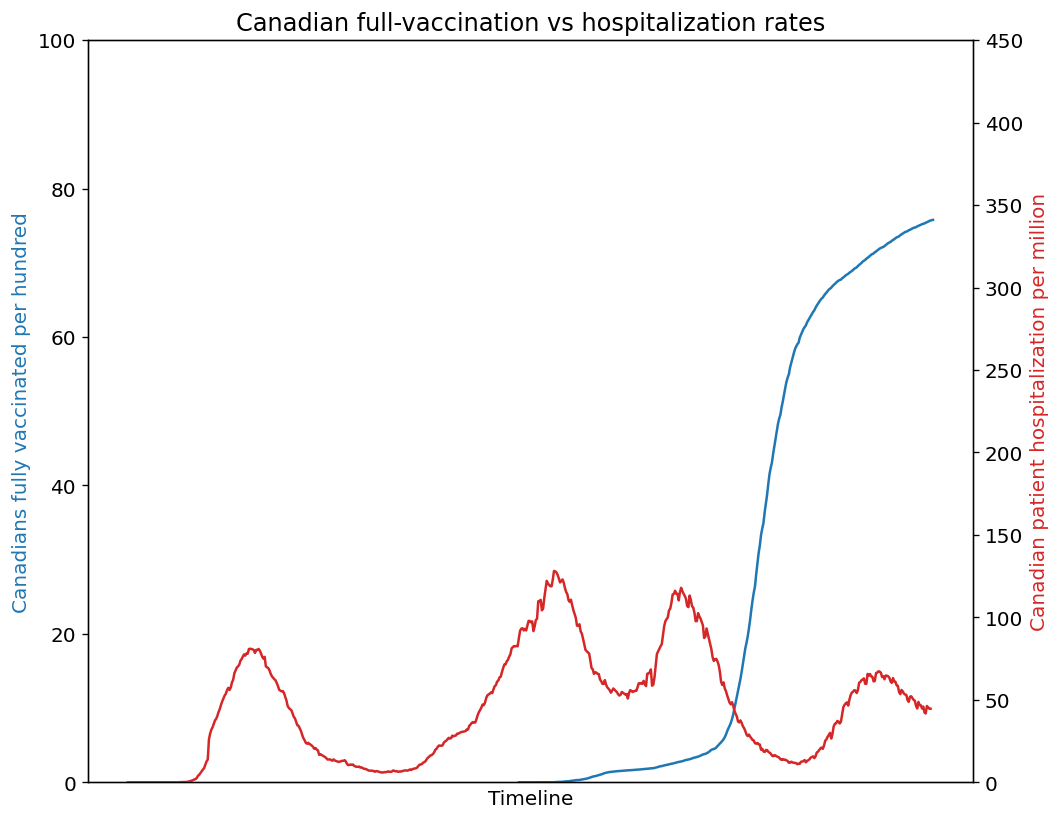

In [149]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_title("Canadian full-vaccination vs hospitalization rates")
ax1.set_xlabel('Timeline')
ax1.set_ylabel('Canadians fully vaccinated per hundred', color = color)
ax1.set_ylim(bottom = 0, top = 100)
ax1.plot(canada_vaccine_df['date'], canada_vaccine_df['people_fully_vaccinated_per_hundred'], color = color)
ax1.tick_params(axis = 'x', which = 'minor', bottom = False)

ax2 = ax1.twinx()

color2 = 'tab:red'
ax2.set_ylabel('Canadian patient hospitalization per million', color = color2)
ax2.plot(canada_hospital_df['date'], canada_hospital_df['hosp_patients_per_million'], color = color2)
ax2.tick_params(axis = 'x', which = 'minor', bottom = False)
ax2.set_ylim(bottom = 0, top = 450)
ax2.set_xticks([], [])


fig.tight_layout()
plt.show()

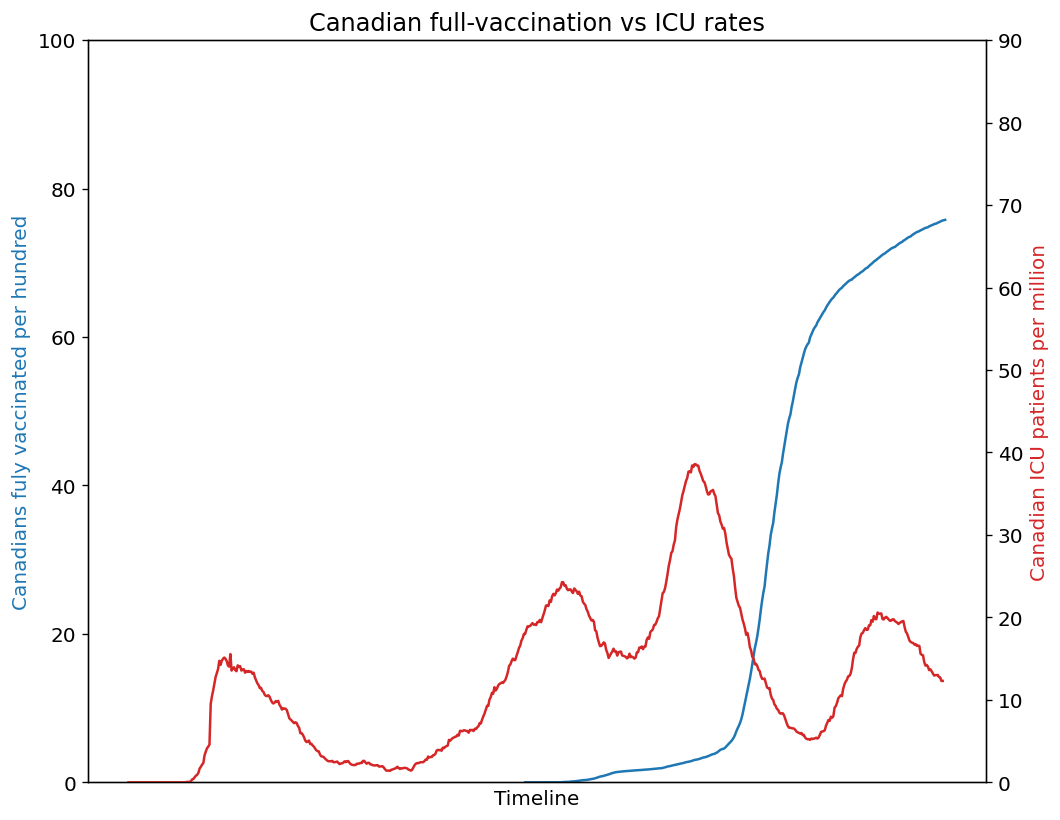

In [150]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_title("Canadian full-vaccination vs ICU rates")
ax1.set_xlabel('Timeline')
ax1.set_ylabel('Canadians fuly vaccinated per hundred', color = color)
ax1.set_ylim(bottom = 0, top = 100)
ax1.plot(canada_vaccine_df['date'], canada_vaccine_df['people_fully_vaccinated_per_hundred'], color = color)
ax1.tick_params(axis = 'x', which = 'minor', bottom = False)

ax2 = ax1.twinx()

color2 = 'tab:red'
ax2.set_ylabel('Canadian ICU patients per million', color = color2)
ax2.plot(canada_hospital_df['date'], canada_hospital_df['icu_patients_per_million'], color = color2)
ax2.tick_params(axis = 'x', which = 'minor', bottom = False)
ax2.set_ylim(bottom = 0, top = 90)
ax2.set_xticks([], [])


fig.tight_layout()
plt.show()

In [151]:
us_hospital_df = covid_hospital_df[covid_hospital_df['location'] == 'United States'].copy()

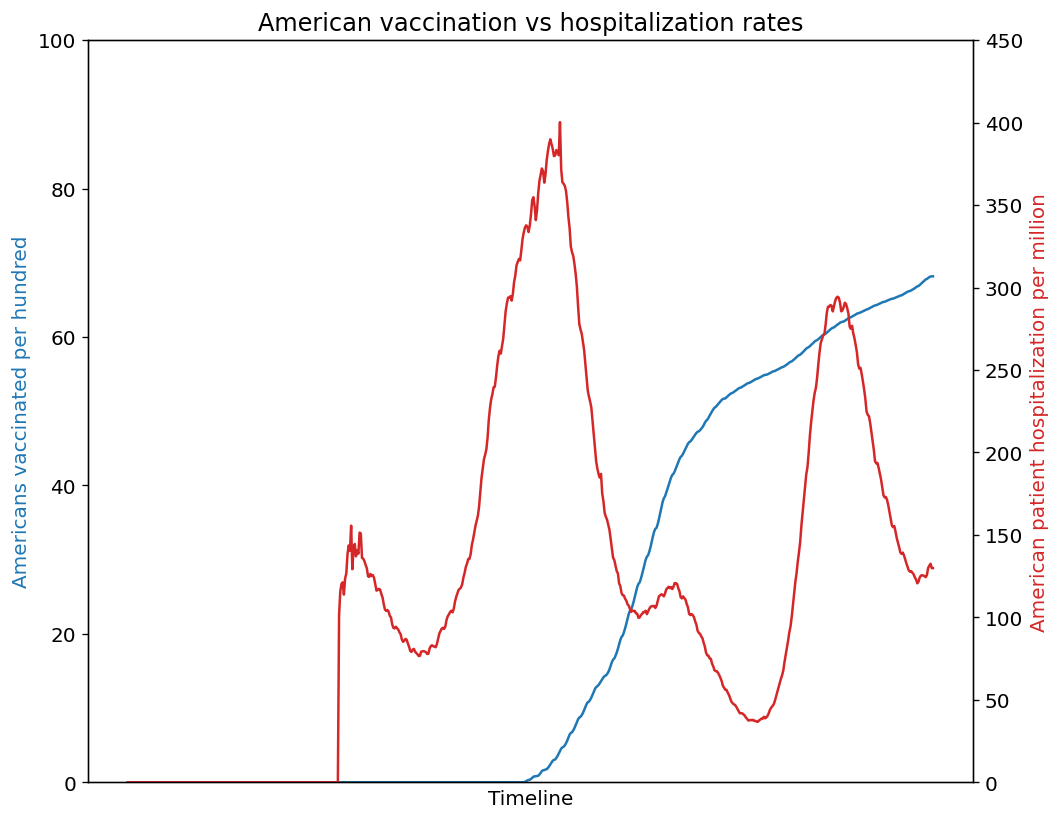

In [152]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_title("American vaccination vs hospitalization rates")
ax1.set_xlabel('Timeline')
ax1.set_ylabel('Americans vaccinated per hundred', color = color)
ax1.set_ylim(bottom = 0, top = 100)
ax1.plot(usa_vaccine_df['date'], usa_vaccine_df['people_vaccinated_per_hundred'], color = color)
ax1.tick_params(axis = 'x', which = 'minor', bottom = False)

ax2 = ax1.twinx()

color2 = 'tab:red'
ax2.set_ylabel('American patient hospitalization per million', color = color2)
ax2.plot(us_hospital_df['date'], us_hospital_df['hosp_patients_per_million'], color = color2)
ax2.tick_params(axis = 'x', which = 'minor', bottom = False)
ax2.set_ylim(bottom = 0, top = 450)
ax2.set_xticks([], [])


fig.tight_layout()
plt.show()


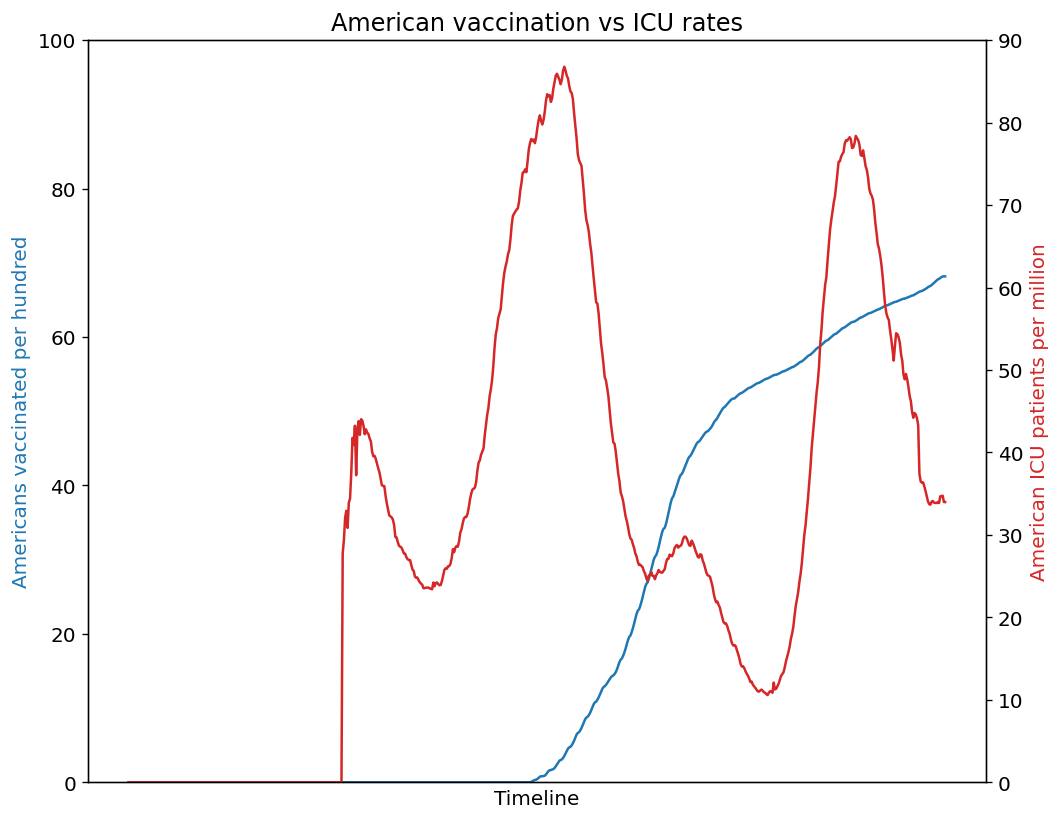

In [153]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_title("American vaccination vs ICU rates")
ax1.set_xlabel('Timeline')
ax1.set_ylabel('Americans vaccinated per hundred', color = color)
ax1.set_ylim(bottom = 0, top = 100)
ax1.plot(usa_vaccine_df['date'], usa_vaccine_df['people_vaccinated_per_hundred'], color = color)
ax1.tick_params(axis = 'x', which = 'minor', bottom = False)

ax2 = ax1.twinx()

color2 = 'tab:red'
ax2.set_ylabel('American ICU patients per million', color = color2)
ax2.plot(us_hospital_df['date'], us_hospital_df['icu_patients_per_million'], color = color2)
ax2.tick_params(axis = 'x', which = 'minor', bottom = False)
ax2.set_ylim(bottom = 0, top = 90)
ax2.set_xticks([], [])


fig.tight_layout()
plt.show()


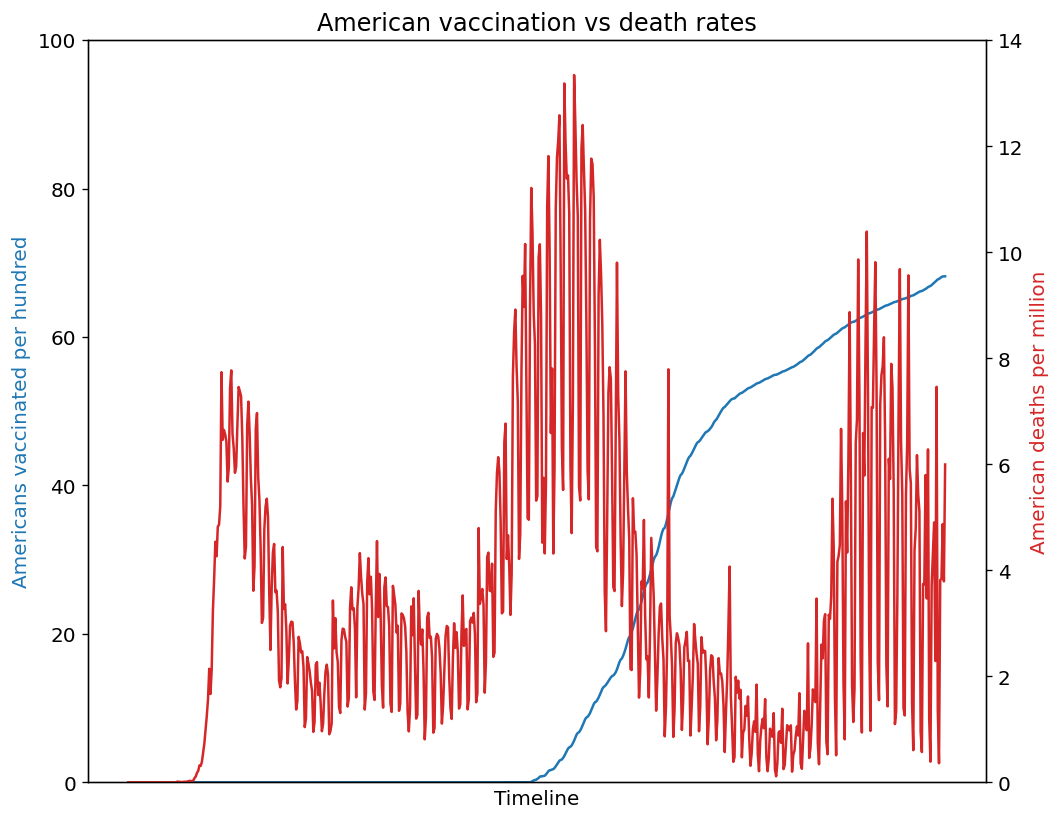

In [154]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_title("American vaccination vs death rates")
ax1.set_xlabel('Timeline')
ax1.set_ylabel('Americans vaccinated per hundred', color = color)
ax1.set_ylim(bottom = 0, top = 100)
ax1.plot(usa_vaccine_df['date'], usa_vaccine_df['people_vaccinated_per_hundred'], color = color)
ax1.tick_params(axis = 'x', which = 'minor', bottom = False)

ax2 = ax1.twinx()

color2 = 'tab:red'
ax2.set_ylabel('American deaths per million', color = color2)
ax2.plot(us_hospital_df['date'], us_hospital_df['new_deaths_per_million'], color = color2)
ax2.tick_params(axis = 'x', which = 'minor', bottom = False)
ax2.set_ylim(bottom = 0, top = 14)
ax2.set_xticks([], [])


fig.tight_layout()
plt.show()


## Discussion

As shown, as Canadian vaccination rates increase, hospitalization, ICU, and death rates decrease significantly. This shows that vaccines do help protect people, and reaching for roughly a 80% vaccination rate has reflected this. However, this does bring up the question on how further lower the rates of hospitalization, ICU, and death rates can be if 90% and even an effectively 100% vaccination rate would look like. In contrast, with the US vaccination in the %70's range have a much higher hospitalization, ICU, and death rates. The most recent peak in hospitalization rates in Canada was roughly 75 hospitalizations per million, as oppossed to 300 per million in the United States. The most recent peak in ICU rates in Canada was roughly 20 per million, while the United States was roughly 80 per million. The most recent peak in death reates in Canada were roughly two per million, while the United States had about 10 per million. With these differences, I can therefore conclude that Canada has the better vaccine rollout. Even though the United States has a higher raw vaccination rate, on a per-hundred basis, Canada's vaccination rate is higher than the United States. This vaccination rate has therefore contributed to helping Canada lower its ICU, hospitalization, and death rates.

As much as I would like to dive deeper and look into quantitative correlation values between the vaccination rates and the hospital/icu/death rates showed above, I need to be aware that finding correlation to the hospitalization count is a multi-faceted problem. Finding a quantitative value to correlate vaccination and these rates implies vaccines are the only factor, but this is not the case. This problem needs to include analysis with respect to other pandemic measures such as social distancing, masking, testing numbers, quarantining, etc. These add further levels of complexity that need to be accounted for, and these analysis are beyond the scope of this report and the data available.